In [1]:
%matplotlib inline
import json
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.time import Time
from collections import OrderedDict
from datetime import datetime
from tqdm import tqdm

matplotlib.style.use('matplotlibrc')

In [2]:
# Define data paths.
records_path = "records.csv"
authors_path = "authors.json"

records = Table.read(records_path)
# Ignore the dummy line, if it exists.
# (I do this to force arxiv identifiers to be strings. It's not a good idea, in general.)
if records["id"][0] == "dummy":
    records = records[1:]
    
# Let's add some useful columns.
records["created_decimal_year"] = Time(records["created"]).decimalyear

with open(authors_path, "r") as fp:
    authors = json.load(fp)

In [3]:
# Sort ascending by ID, as it will be useful later on.
#records.sort(["id"])

In [4]:
# How we will define a 'unique' author.
def unique_ify(author_name):
    given, last = author_name
    try:
        first_initial = f"{given[0].strip()[:1]}."
    except IndexError:
        return f"{last.strip()}"
    else:
        return f"{last.strip()}, {first_initial}"
    
# Get date (to ~month granularity) from an arxiv ID
get_date = lambda arxiv_id: (int(f"20{arxiv_id[:2]}"), int(arxiv_id[2:4]))
def get_decimal_date(arxiv_id):
    year, month = get_date(arxiv_id)
    return year + (month - 1)/12


In [5]:
# Want unique number of author names as a function of time.
def get_unique_author_names(arxiv_ids, bins=np.arange(2008, 2021, 1/12)):
    d = np.array(list(map(get_decimal_date, arxiv_ids)))
    idx = np.digitize(d, bins)
    
    y = np.zeros(bins.size - 1)
    
    for i, bin_edge in enumerate(tqdm(bins[:-1])):
        mask = (idx == (i + 1))
        authors_in_bin = []
        for arxiv_id in arxiv_ids[mask]:
            authors_in_bin.extend(list(map(unique_ify, authors[arxiv_id])))
        
        y[i] = len(set(authors_in_bin))
    
    return (y, bins)


# Build field-specific profiles
data_unique = []
for ppc in sorted(list(set(records["primary_parent_category"]))):
    mask = (records["primary_parent_category"] == ppc)
    y, bins = get_unique_author_names(records["id"][mask])
    data_unique.append((ppc, y, bins))



100%|██████████| 155/155 [00:00<00:00, 1126.95it/s]


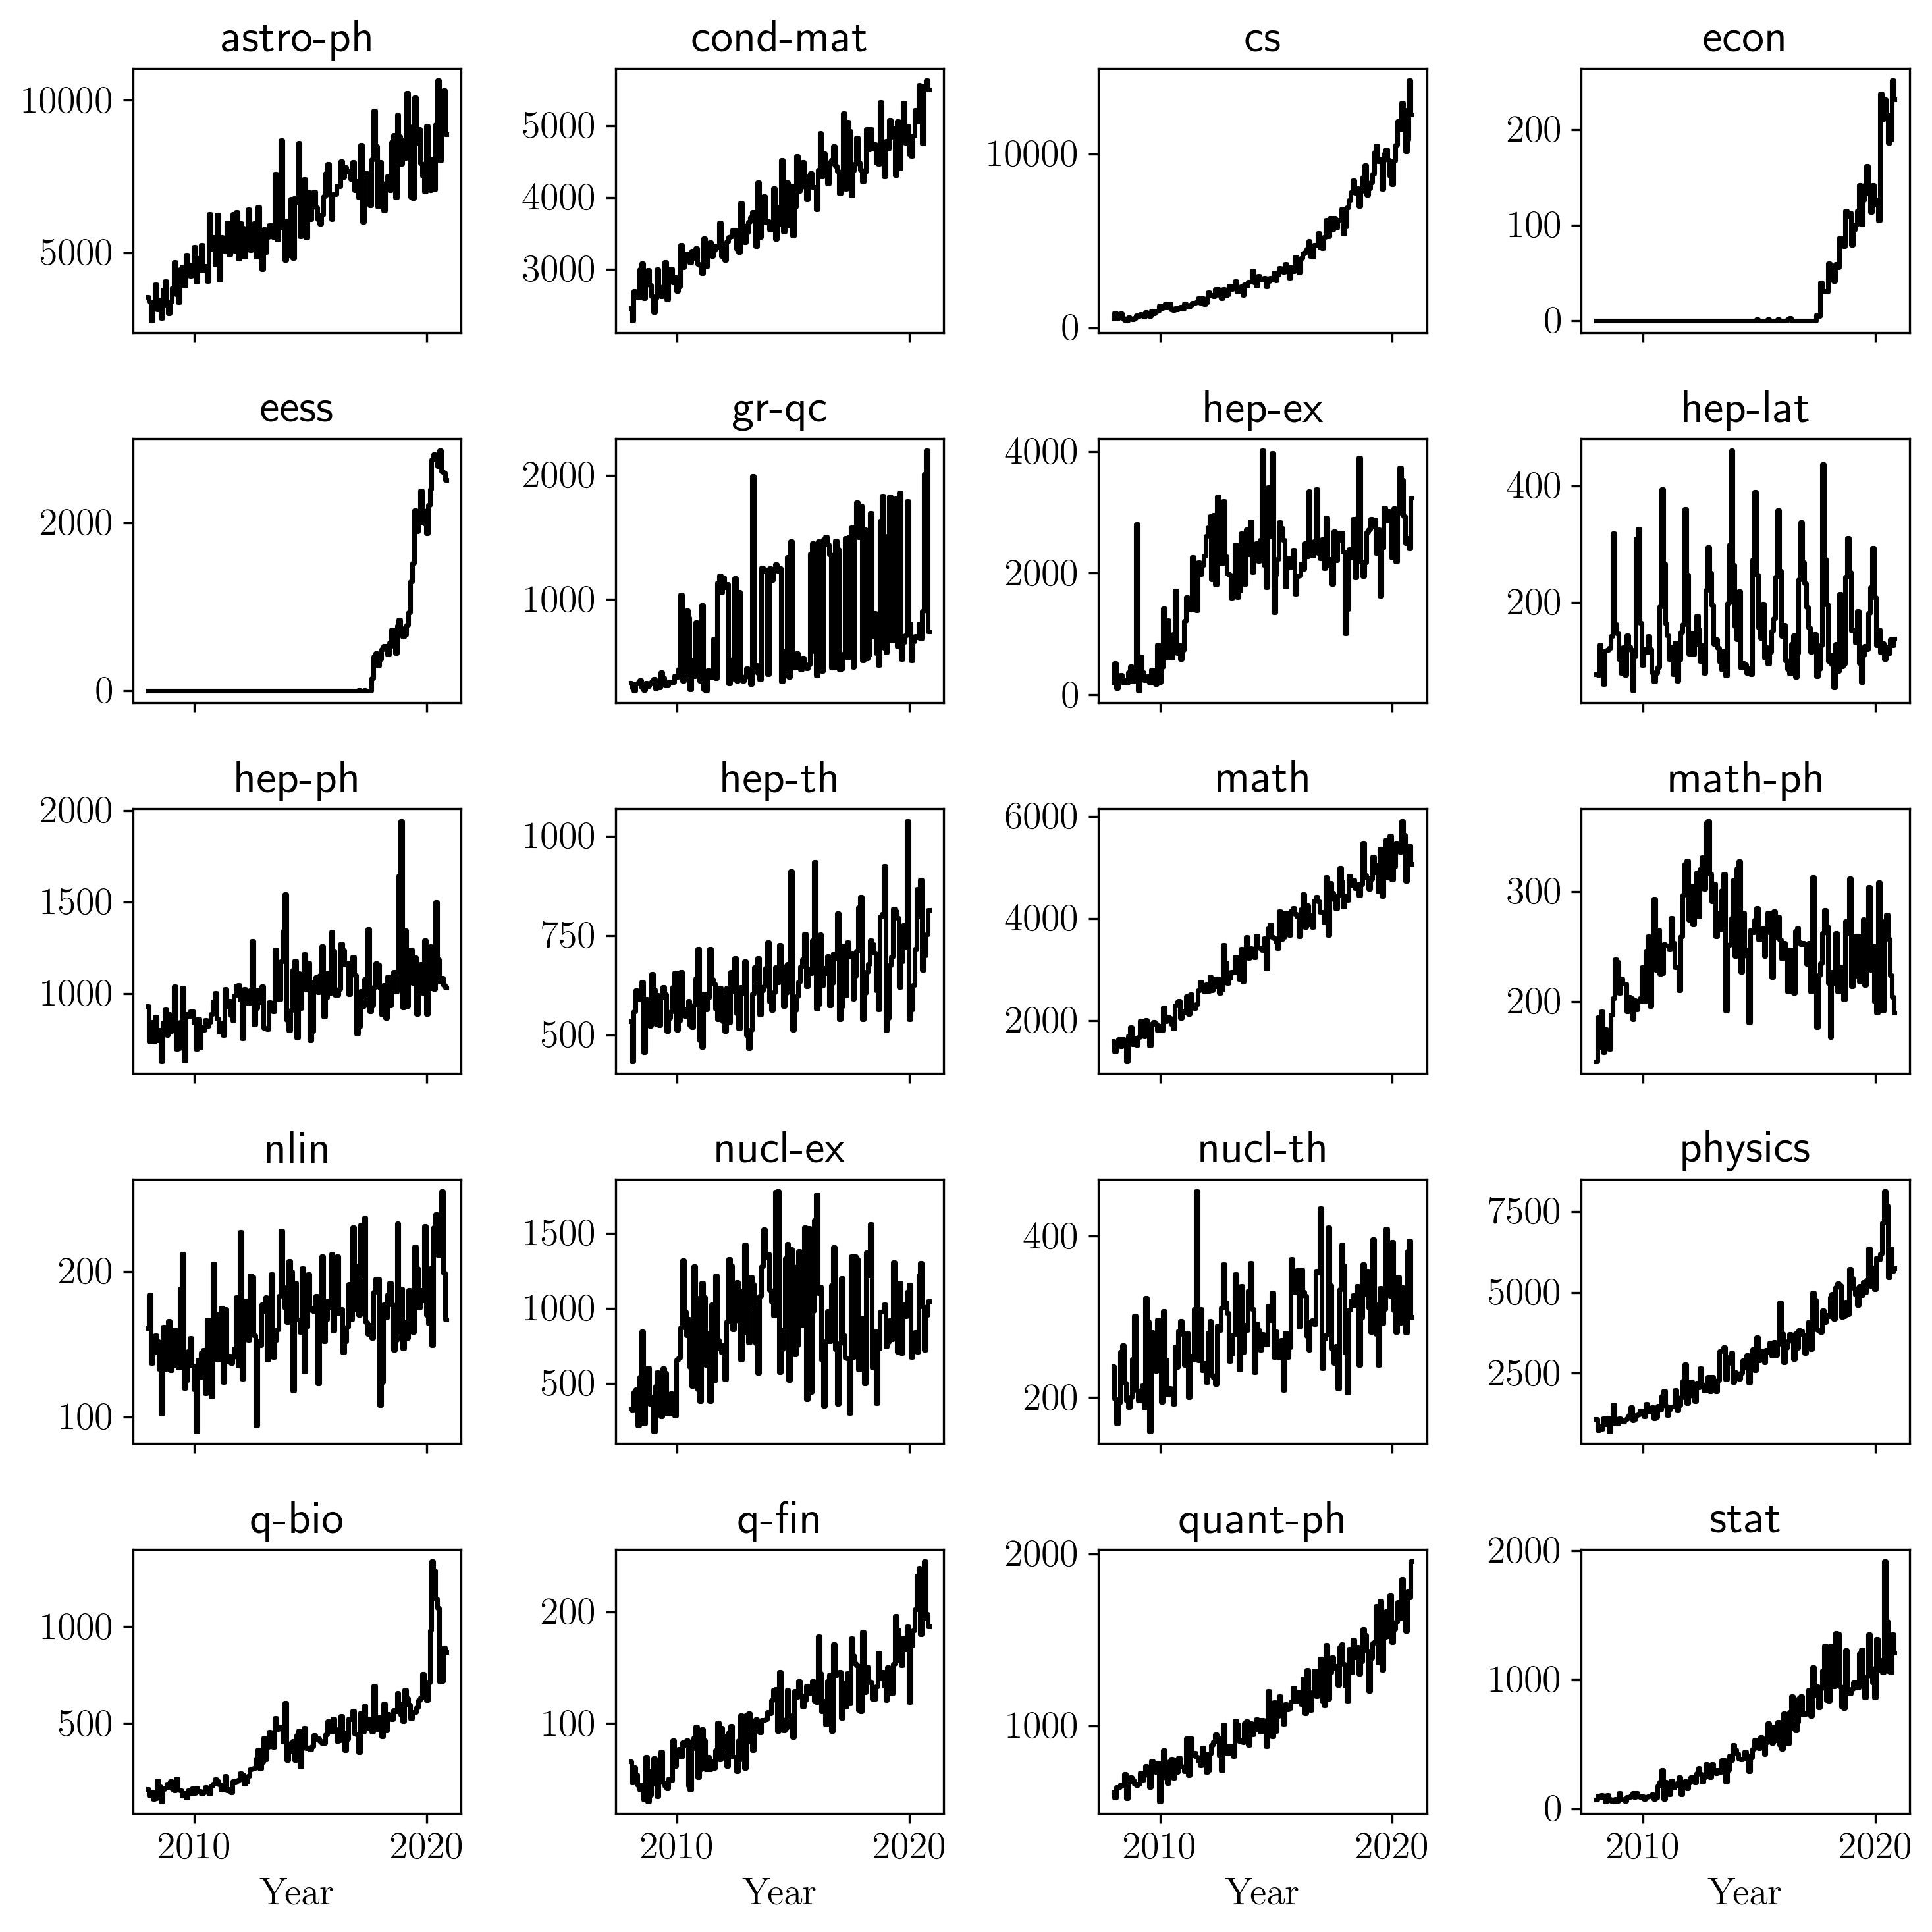

In [6]:
fig, axes = plt.subplots(5, 4)
axes = np.array(axes).flatten()
for ax, (ppc, y, bins) in zip(axes, data_unique):
    ax.plot(
        bins[:-1],
        y,
        drawstyle="steps-mid",
        c="k"
    )
    ax.set_title(ppc)
    
    if ax.is_last_row():
        ax.set_xlabel(r"$\textrm{Year}$")
    else:
        ax.set_xticklabels([])
    
#axes[8].set_ylabel(f"Number of unique authors")

fig.tight_layout()
fig.savefig("article/unique-authors-segmented-by-field.pdf", dpi=300)

Text(0, 0.5, 'Number of unique authors')

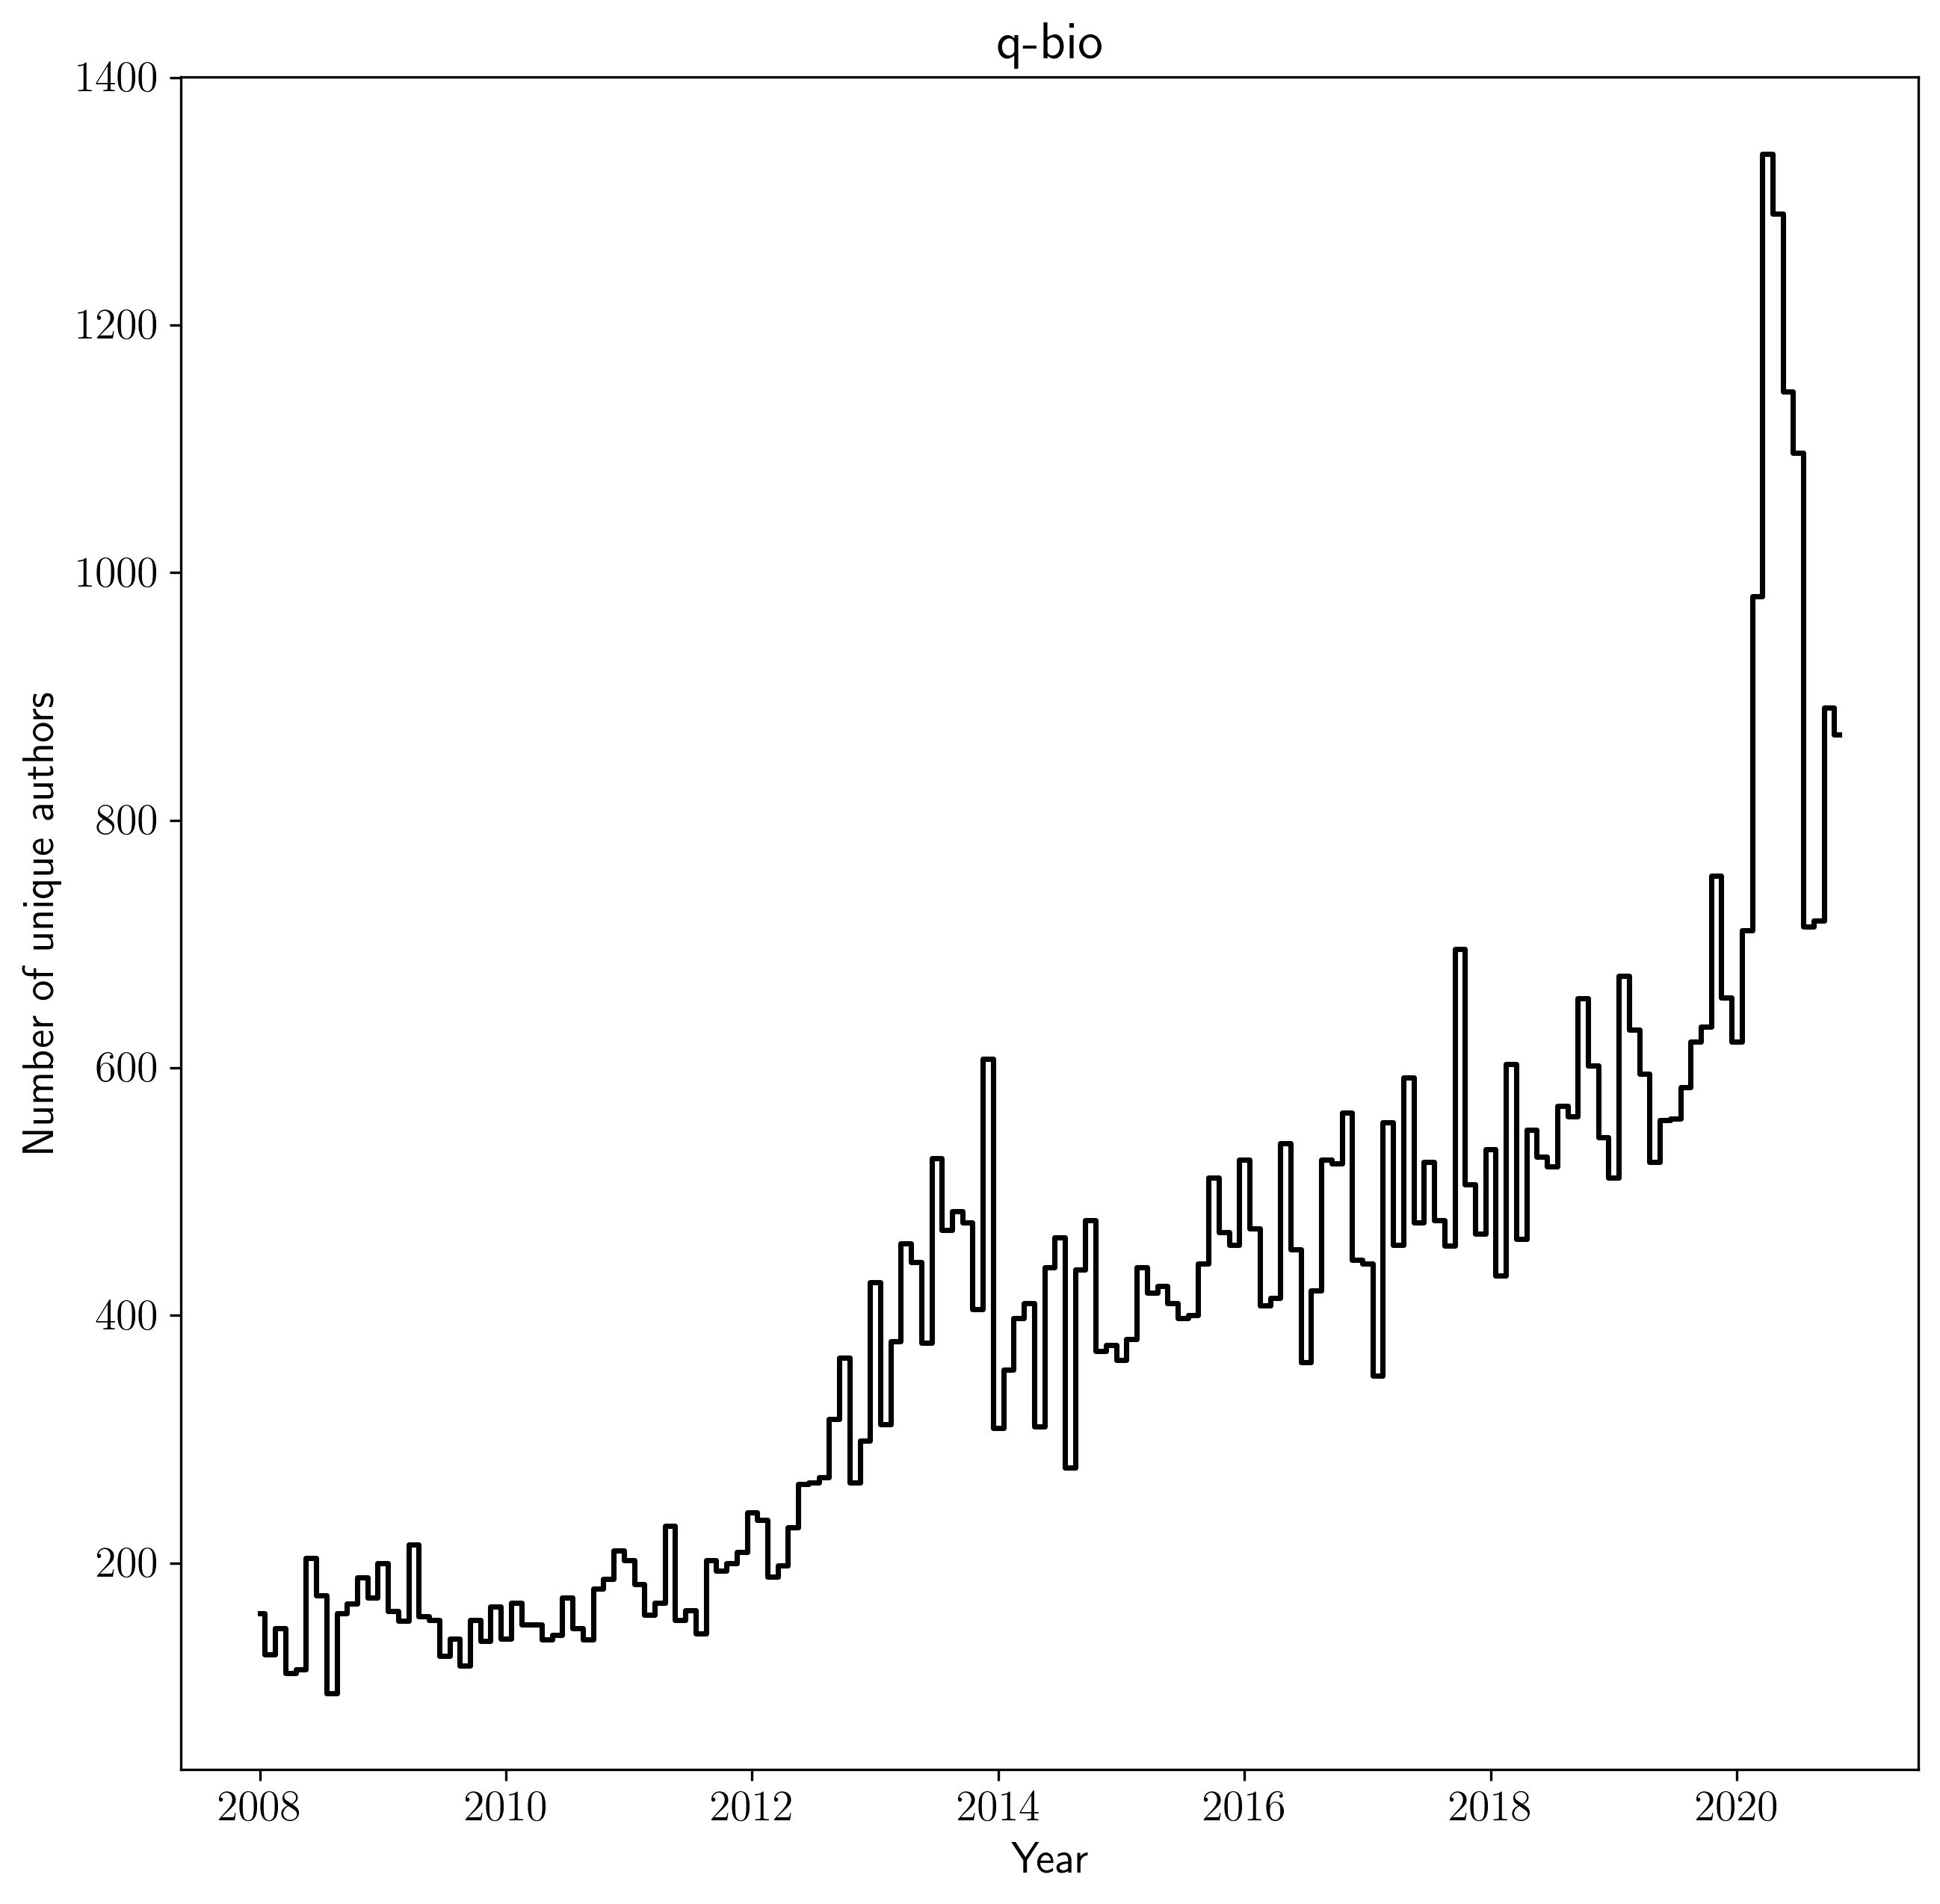

In [7]:
for ppc, y, bins in data_unique:
    if ppc == "q-bio":
        break

fig, ax = plt.subplots()
ax.plot(
    bins[:-1],
    y,
    drawstyle="steps-mid",
    c="k"
)
ax.set_title(ppc)
ax.set_xlabel(r"Year")
ax.set_ylabel(r"Number of unique authors")

Text(0, 0.5, 'Number of unique authors')

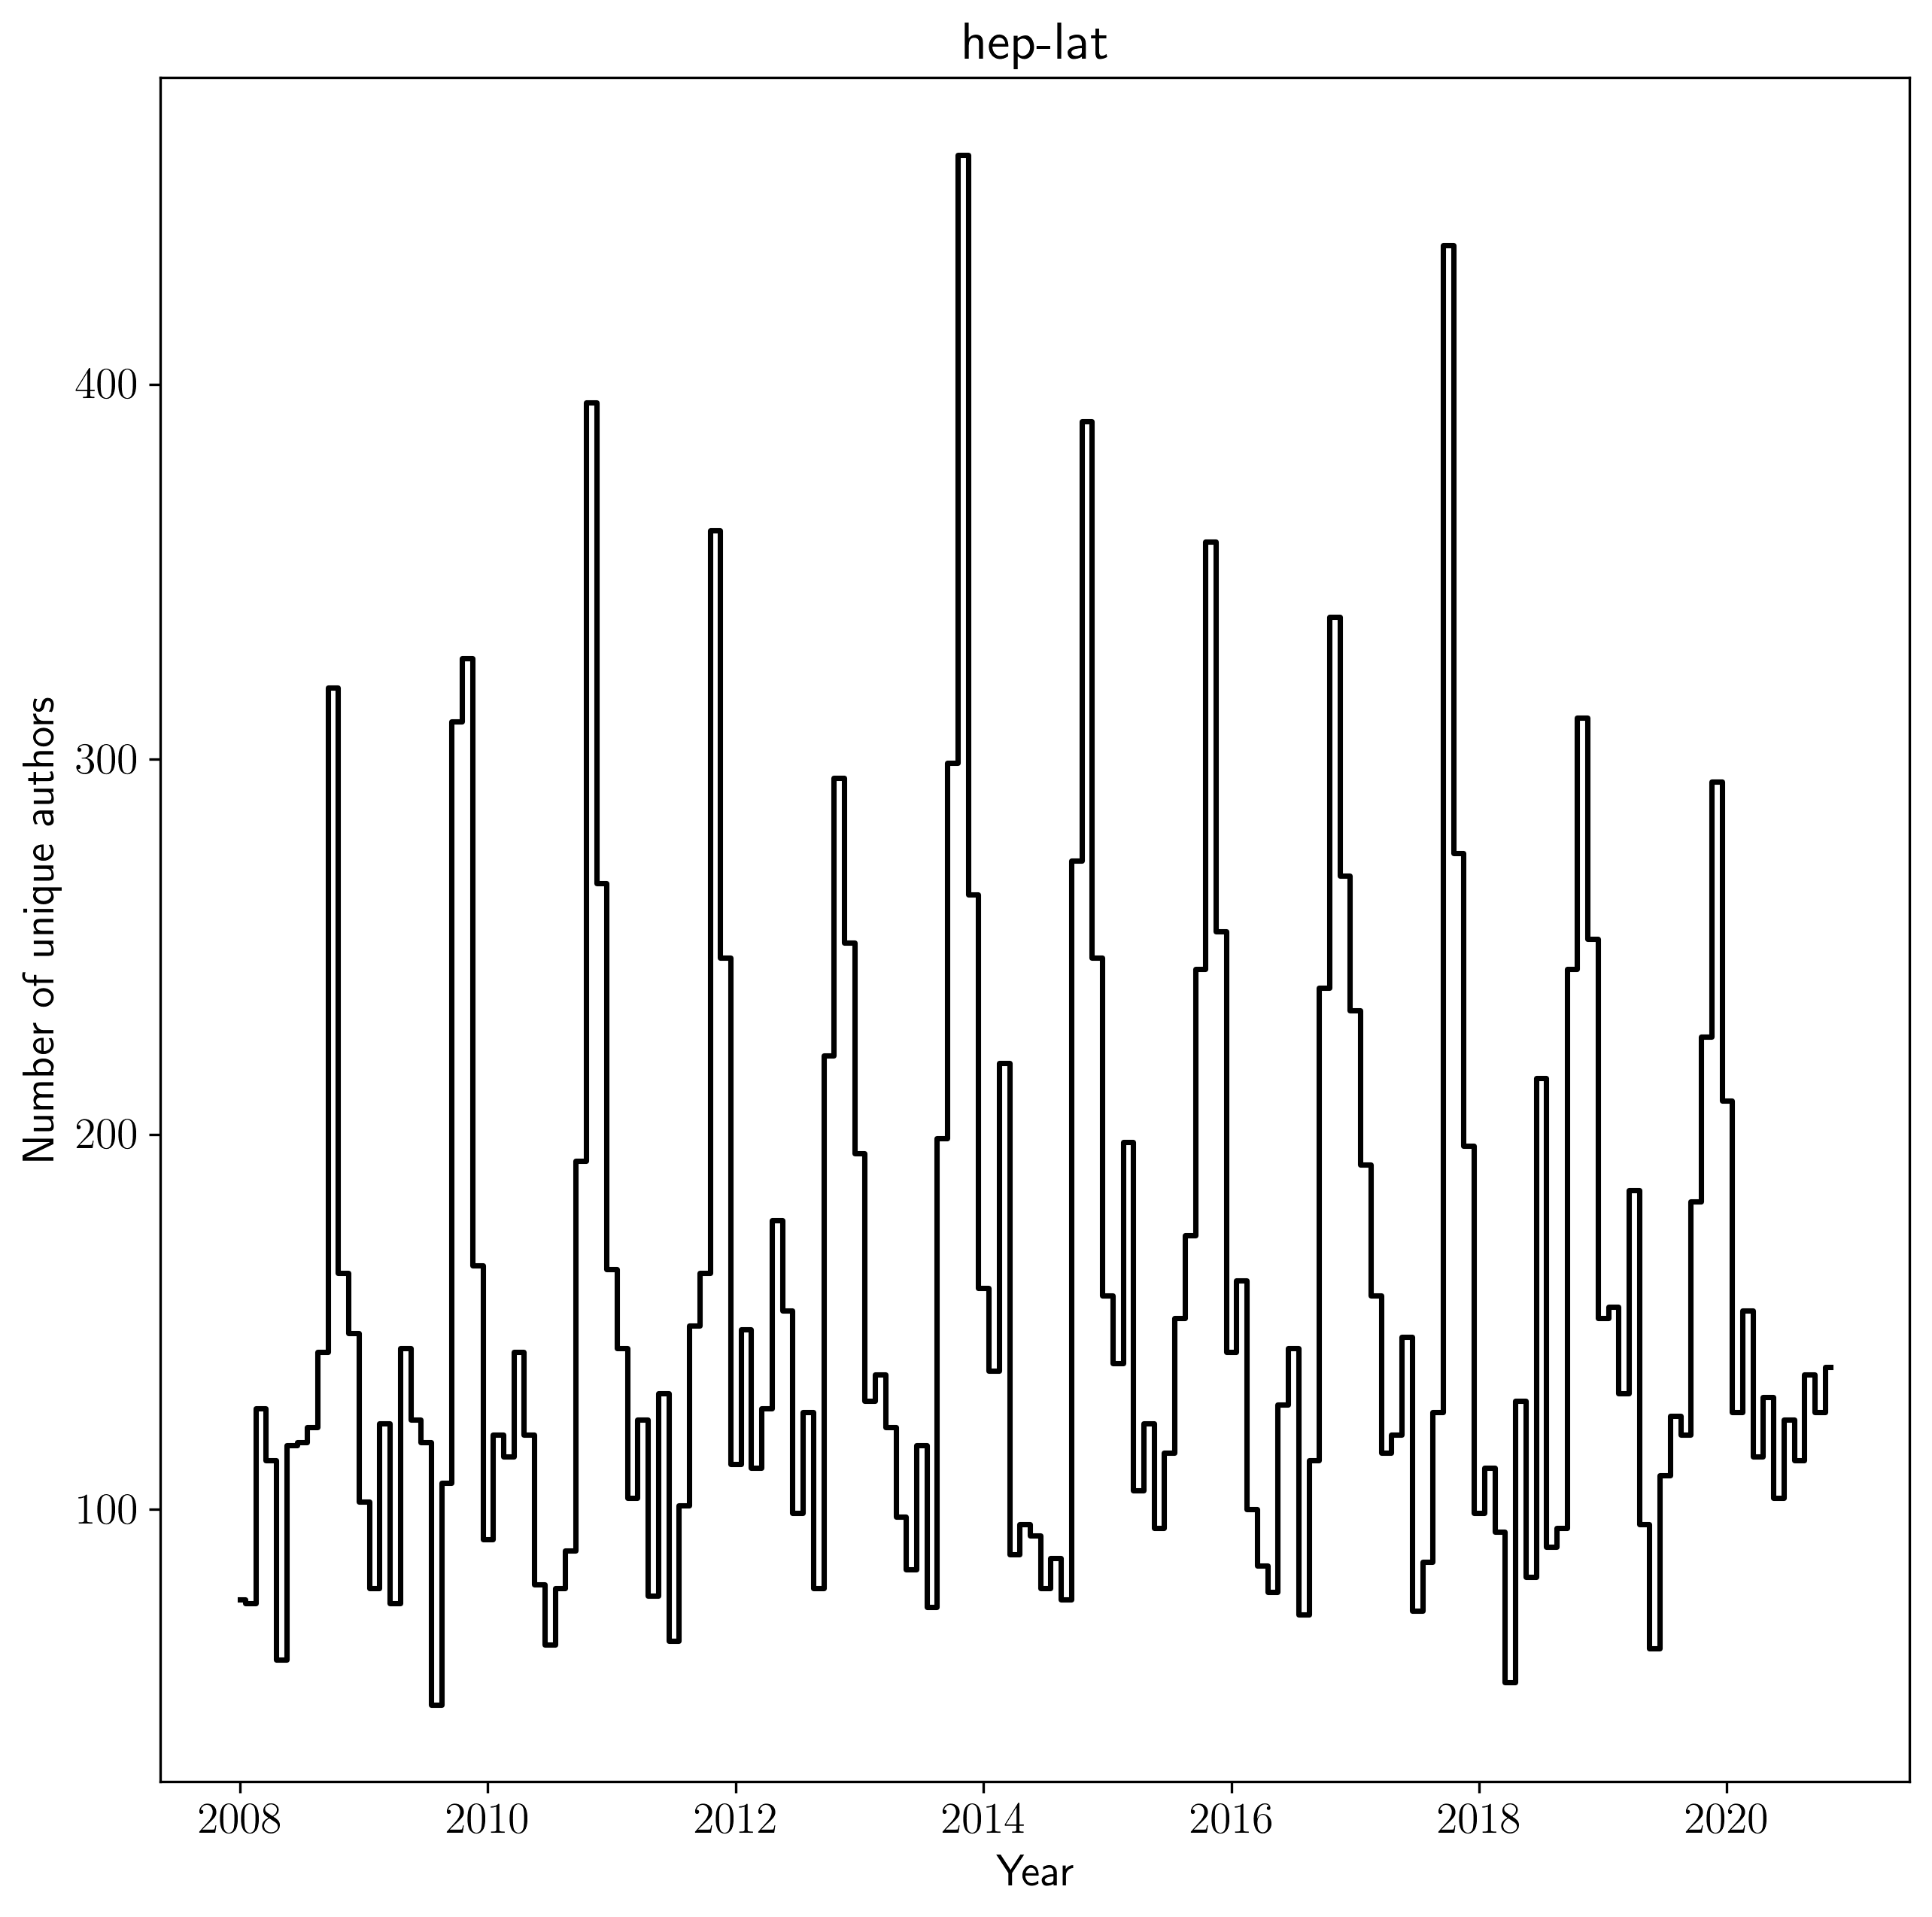

In [8]:
for ppc, y, bins in data_unique:
    if ppc == "hep-lat":
        break

fig, ax = plt.subplots()
ax.plot(
    bins[:-1],
    y,
    drawstyle="steps-mid",
    c="k"
)
ax.set_title(ppc)
ax.set_xlabel(r"Year")
ax.set_ylabel(r"Number of unique authors")

In [9]:
# Is the biology peak due to biologists suddenly working with lots of people outside 
# of their field, or is it due to people outside of the field publishing in biology?

# Let's check number of unique people leading papers per field to test.

# Want unique number of author names as a function of time.
def get_unique_leading_author_names(arxiv_ids, bins=np.arange(2008, 2021, 1/12)):
    d = np.array(list(map(get_decimal_date, arxiv_ids)))
    idx = np.digitize(d, bins)
    
    y = np.zeros(bins.size - 1)
    
    for i, bin_edge in tqdm(enumerate(bins[:-1])):
        mask = (idx == (i + 1))
        authors_in_bin = []
        for arxiv_id in arxiv_ids[mask]:
            authors_in_bin.append(unique_ify(authors[arxiv_id][0]))        
        y[i] = len(set(authors_in_bin))
    
    return (y, bins)


# Build field-specific profiles
data_unique_leading = []
for ppc in sorted(list(set(records["primary_parent_category"]))):
    mask = (records["primary_parent_category"] == ppc)
    y, bins = get_unique_leading_author_names(records["id"][mask])
    data_unique_leading.append((ppc, y, bins))

155it [00:00, 309.06it/s]
155it [00:00, 384.82it/s]
155it [00:00, 306.78it/s]
155it [00:00, 15813.32it/s]
155it [00:00, 3400.83it/s]
155it [00:00, 2429.62it/s]
155it [00:00, 3466.92it/s]
155it [00:00, 7017.07it/s]
155it [00:00, 1218.21it/s]
155it [00:00, 1694.32it/s]
155it [00:00, 261.62it/s]
155it [00:00, 3190.74it/s]
155it [00:00, 5668.13it/s]
155it [00:00, 6978.50it/s]
155it [00:00, 2916.98it/s]
155it [00:00, 696.40it/s]
155it [00:00, 3060.22it/s]
155it [00:00, 6074.67it/s]
155it [00:00, 1071.28it/s]
155it [00:00, 1872.14it/s]


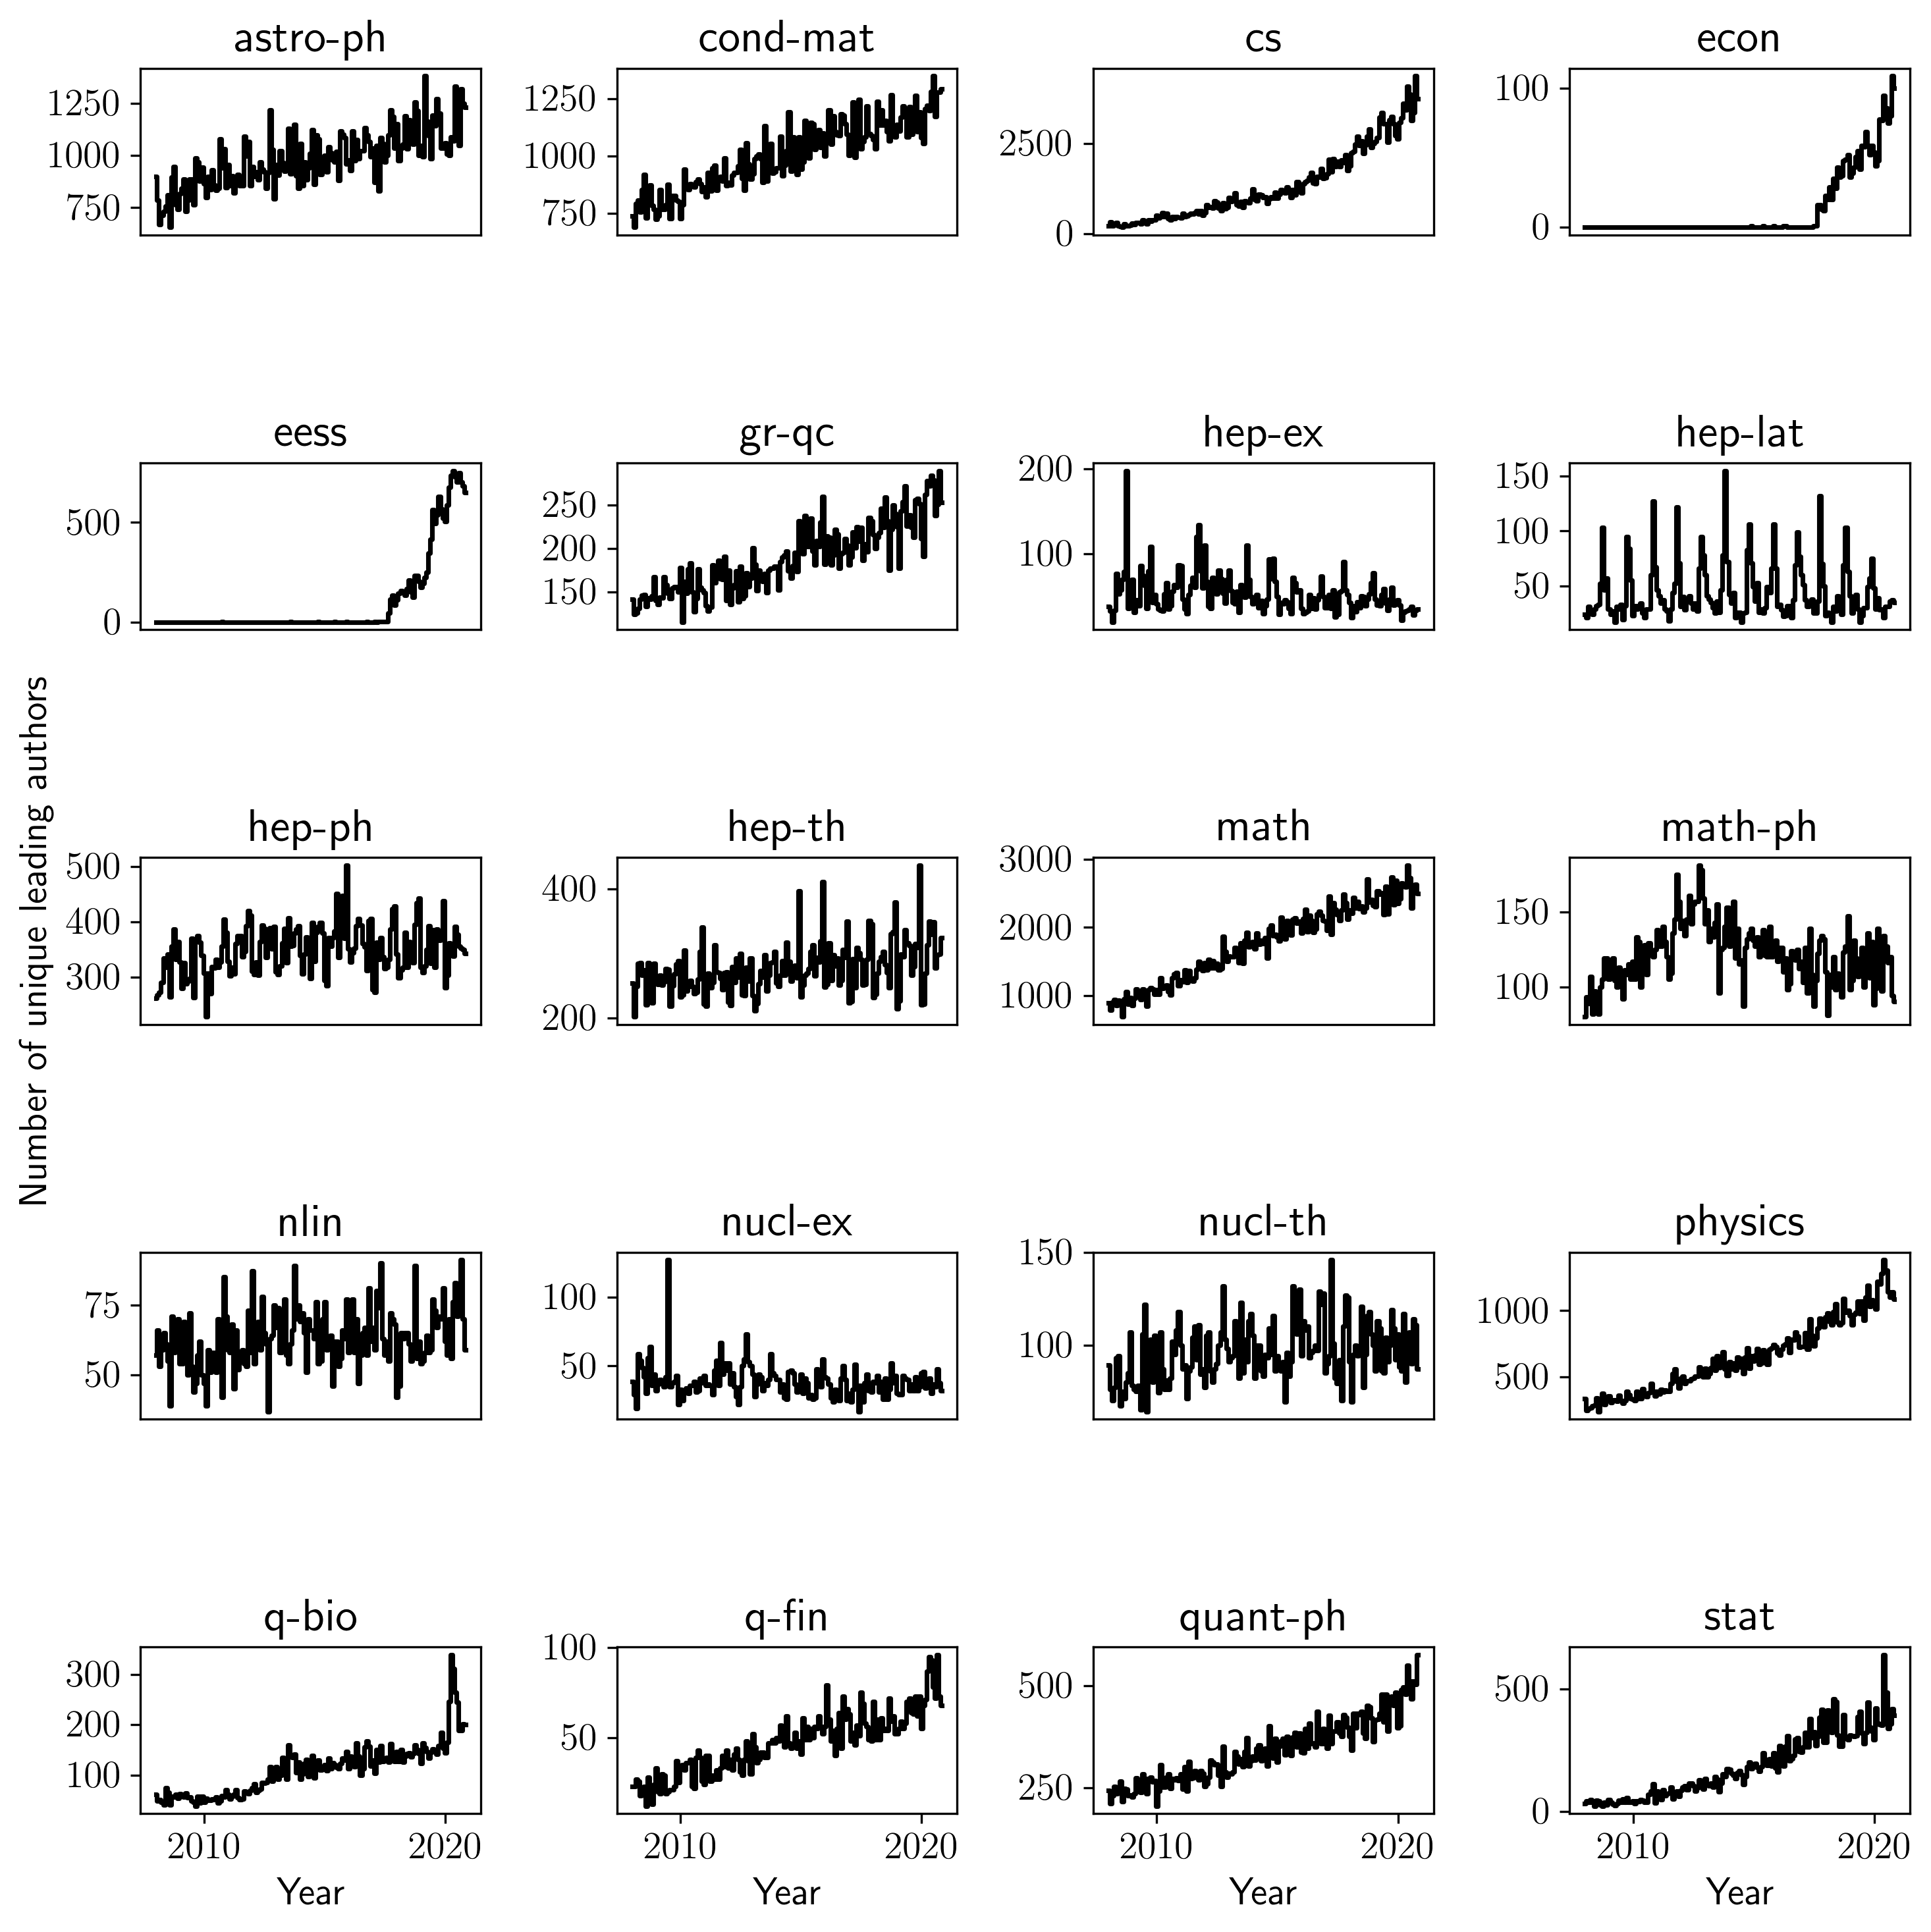

In [10]:
fig, axes = plt.subplots(5, 4)
axes = np.array(axes).flatten()
for ax, (ppc, y, bins) in zip(axes, data_unique_leading):
    ax.plot(
        bins[:-1],
        y,
        drawstyle="steps-mid",
        c="k"
    )
    ax.set_title(ppc)
    
    if not ax.is_last_row():
        ax.set_xticks([])
    else:
        ax.set_xlabel(r"Year")
    

axes[8].set_ylabel(r"Number of unique leading authors")

fig.tight_layout()

In [11]:
# Ha! A whole bunch of 'new' people started leading papers in biology in 2020.
# Let's see if they are indeed new people, or well-established, or something.

# First let's check variance in last names: biology might put leading author at end.
# Is the biology peak due to biologists suddenly working with lots of people outside 
# of their field, or is it due to people outside of the field publishing in biology?

# Let's check number of unique people leading papers per field to test.

# Want unique number of author names as a function of time.
def get_unique_trailing_author_names(arxiv_ids, bins=np.arange(2008, 2021, 1/12)):
    d = np.array(list(map(get_decimal_date, arxiv_ids)))
    idx = np.digitize(d, bins)
    
    y = np.zeros(bins.size - 1)
    
    for i, bin_edge in tqdm(enumerate(bins[:-1])):
        mask = (idx == (i + 1))
        authors_in_bin = []
        for arxiv_id in arxiv_ids[mask]:
            authors_in_bin.append(unique_ify(authors[arxiv_id][-1]))        
        y[i] = len(set(authors_in_bin))
    
    return (y, bins)


# Build field-specific profiles
data_unique_trailing = []
for ppc in sorted(list(set(records["primary_parent_category"]))):
    mask = (records["primary_parent_category"] == ppc)
    y, bins = get_unique_trailing_author_names(records["id"][mask])
    data_unique_trailing.append((ppc, y, bins))

155it [00:00, 390.09it/s]
155it [00:00, 416.68it/s]
155it [00:00, 248.58it/s]
155it [00:00, 15395.40it/s]
155it [00:00, 3674.81it/s]
155it [00:00, 2094.28it/s]
155it [00:00, 4738.46it/s]
155it [00:00, 5497.21it/s]
155it [00:00, 1048.84it/s]
155it [00:00, 1574.21it/s]
155it [00:00, 178.91it/s]
155it [00:00, 2216.82it/s]
155it [00:00, 5084.64it/s]
155it [00:00, 5366.13it/s]
155it [00:00, 3914.25it/s]
155it [00:00, 605.95it/s]
155it [00:00, 3360.21it/s]
155it [00:00, 7147.44it/s]
155it [00:00, 1248.95it/s]
155it [00:00, 2020.52it/s]


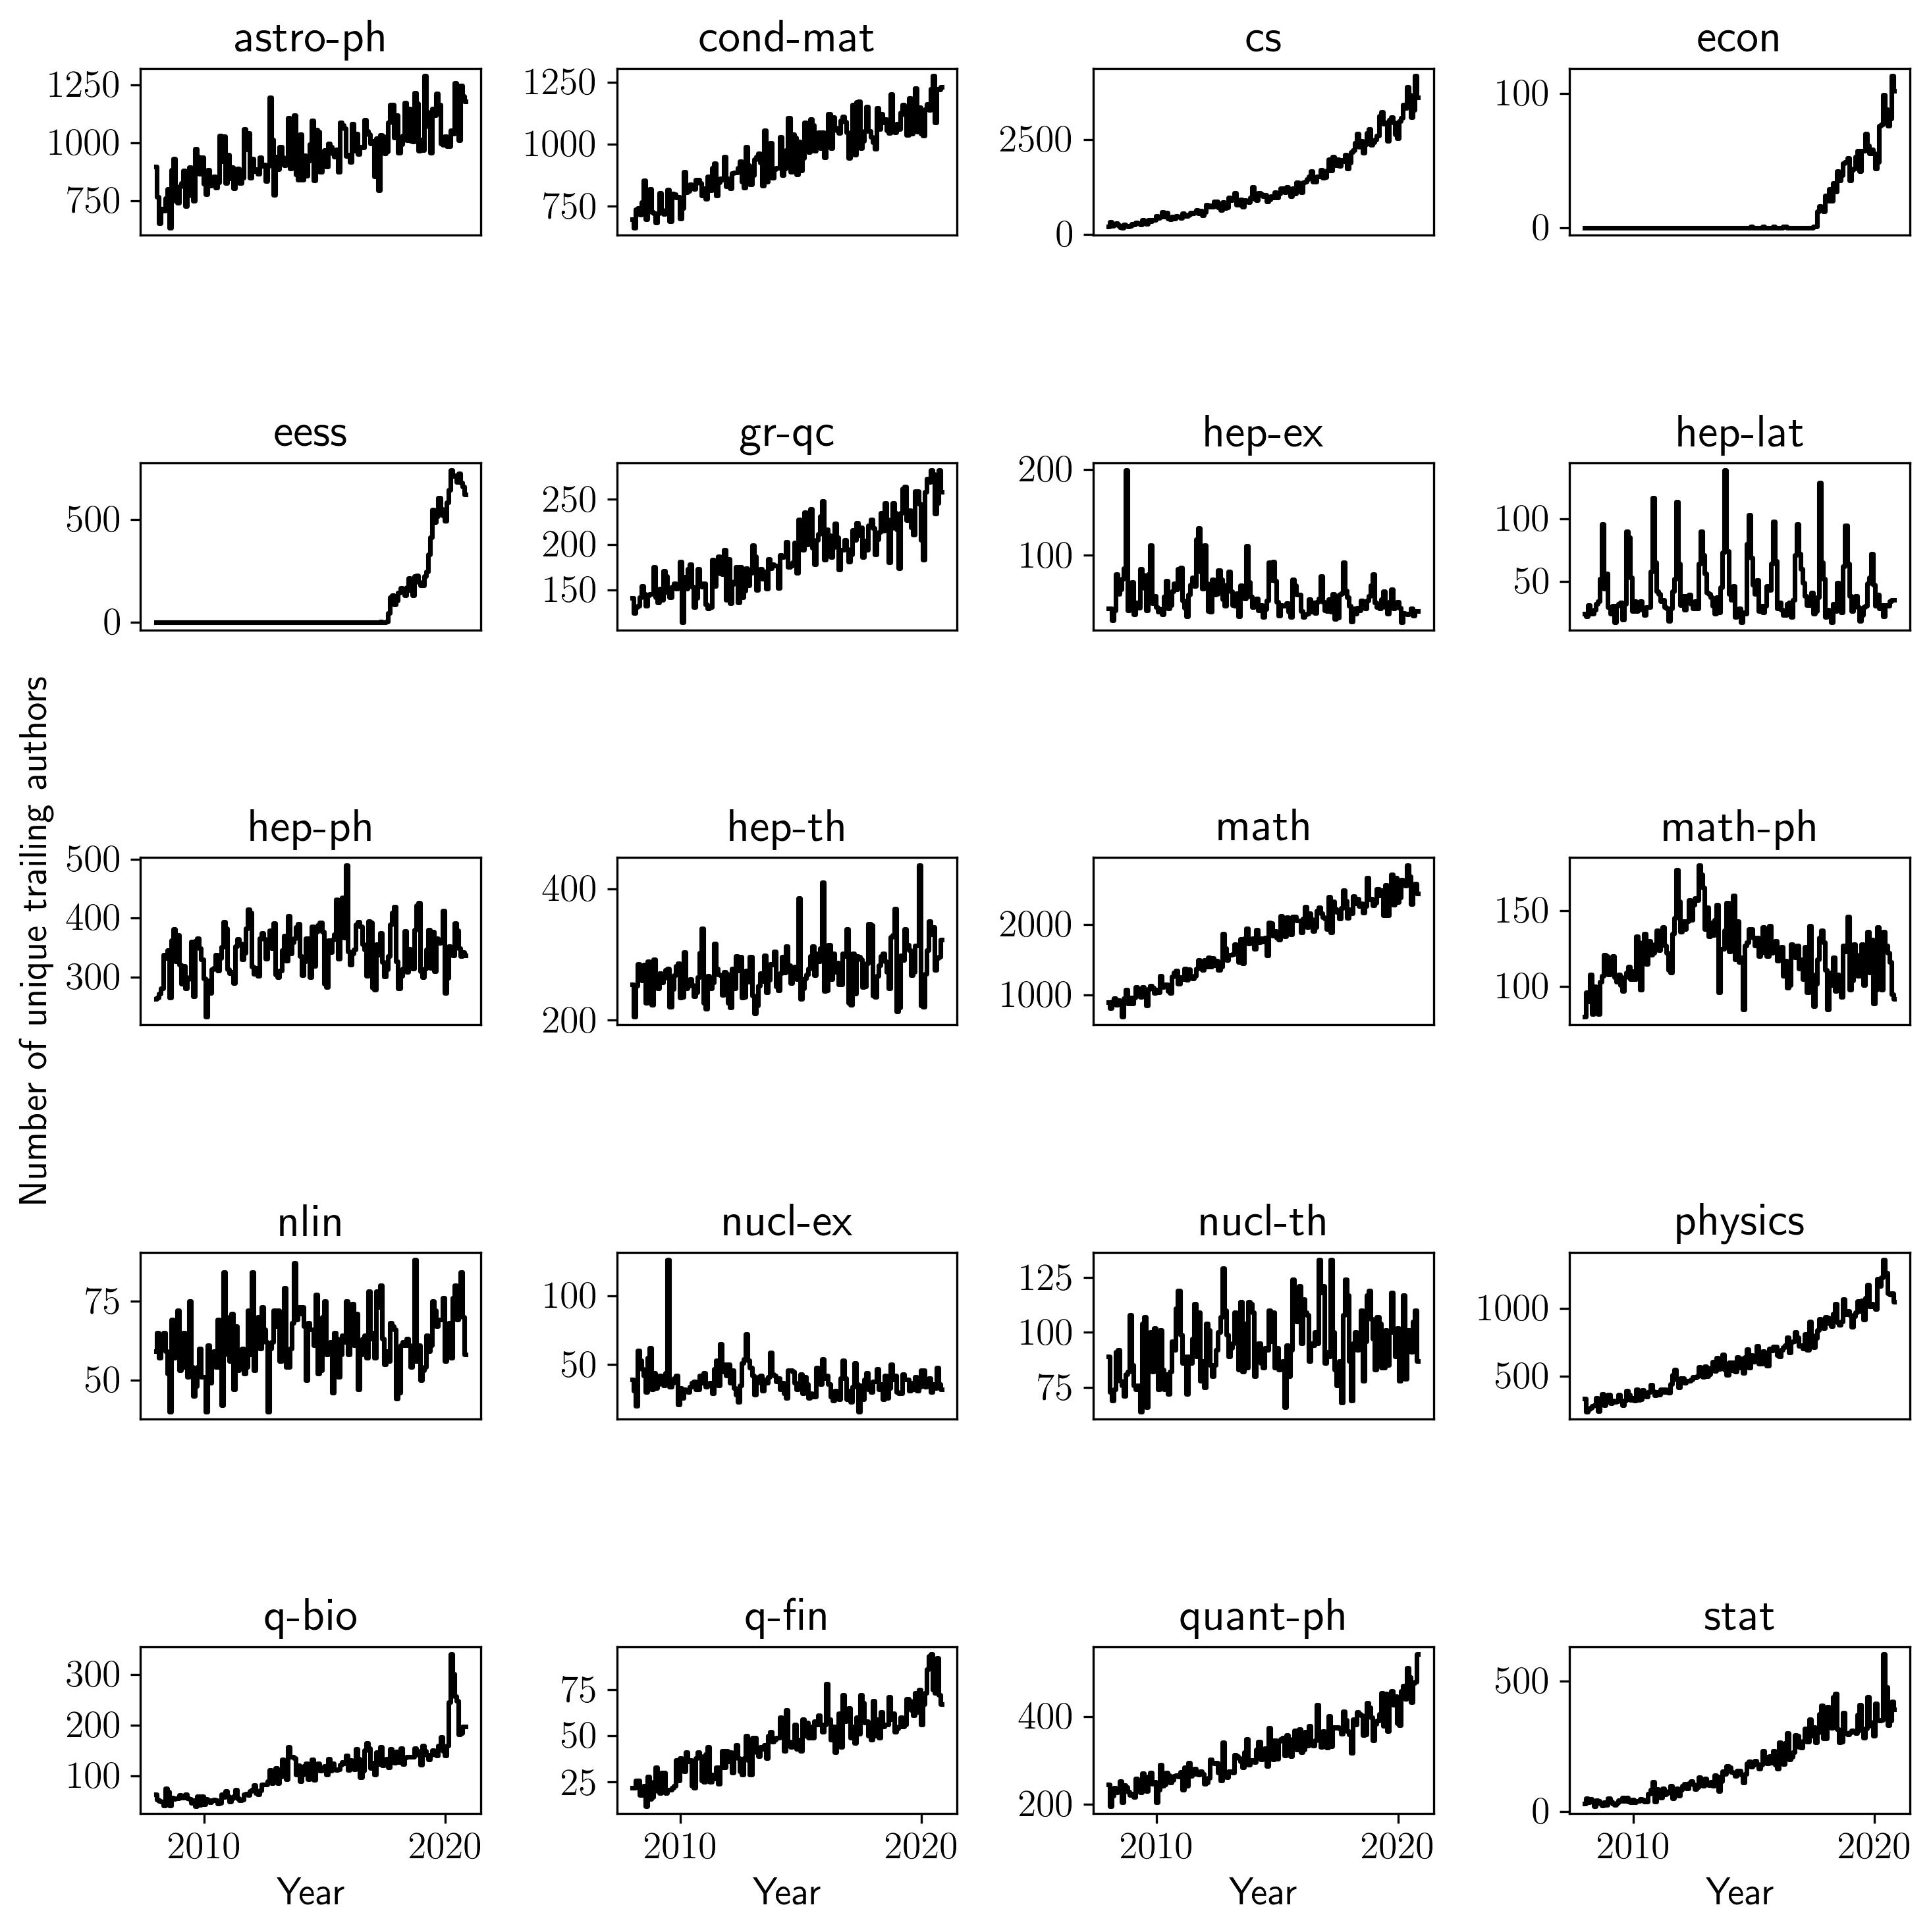

In [12]:
fig, axes = plt.subplots(5, 4)
axes = np.array(axes).flatten()
for ax, (ppc, y, bins) in zip(axes, data_unique_trailing):
    ax.plot(
        bins[:-1],
        y,
        drawstyle="steps-mid",
        c="k"
    )
    ax.set_title(ppc)
    
    if not ax.is_last_row():
        ax.set_xticks([])
    else:
        ax.set_xlabel(r"Year")
    

axes[8].set_ylabel(r"Number of unique trailing authors")

fig.tight_layout()

In [13]:
# Hmm. Let's see how many 'new' names entered a field with time.
# That is to say: the name had never appeared in the literature until then.

def get_new_authors(arxiv_ids, bins=np.arange(2008, 2021, 1/12)):
    d = np.array(list(map(get_decimal_date, arxiv_ids)))
    idx = np.digitize(d, bins)
    
    y = np.zeros(bins.size - 1)
    has_appeared = []
    for i, bin_edge in tqdm(enumerate(bins[:-1])):
        mask = (idx == (i + 1))
        authors_in_bin = []
        for arxiv_id in arxiv_ids[mask]:
            authors_in_bin.extend(list(map(unique_ify, authors[arxiv_id])))
        
        new_names = set(authors_in_bin).difference(has_appeared)
        y[i] = len(new_names)
        has_appeared.extend(list(new_names))
    
    return (y, bins)


# Build field-specific profiles
data_new_authors = []
for ppc in sorted(list(set(records["primary_parent_category"]))):
    mask = (records["primary_parent_category"] == ppc)
    y, bins = get_new_authors(records["id"][mask])
    data_new_authors.append((ppc, y, bins))

155it [00:01, 99.94it/s]
155it [00:01, 124.93it/s]
155it [00:01, 131.26it/s]
155it [00:00, 10164.43it/s]
155it [00:00, 1625.01it/s]
155it [00:00, 866.54it/s] 
155it [00:00, 278.43it/s]
155it [00:00, 3322.33it/s]
155it [00:00, 580.52it/s]
155it [00:00, 808.65it/s]
155it [00:01, 138.07it/s]
155it [00:00, 1930.89it/s]
155it [00:00, 2789.08it/s]
155it [00:00, 822.33it/s]
155it [00:00, 1876.49it/s]
155it [00:00, 191.39it/s]
155it [00:00, 1051.74it/s]
155it [00:00, 3307.24it/s]
155it [00:00, 502.10it/s]
155it [00:00, 993.61it/s] 


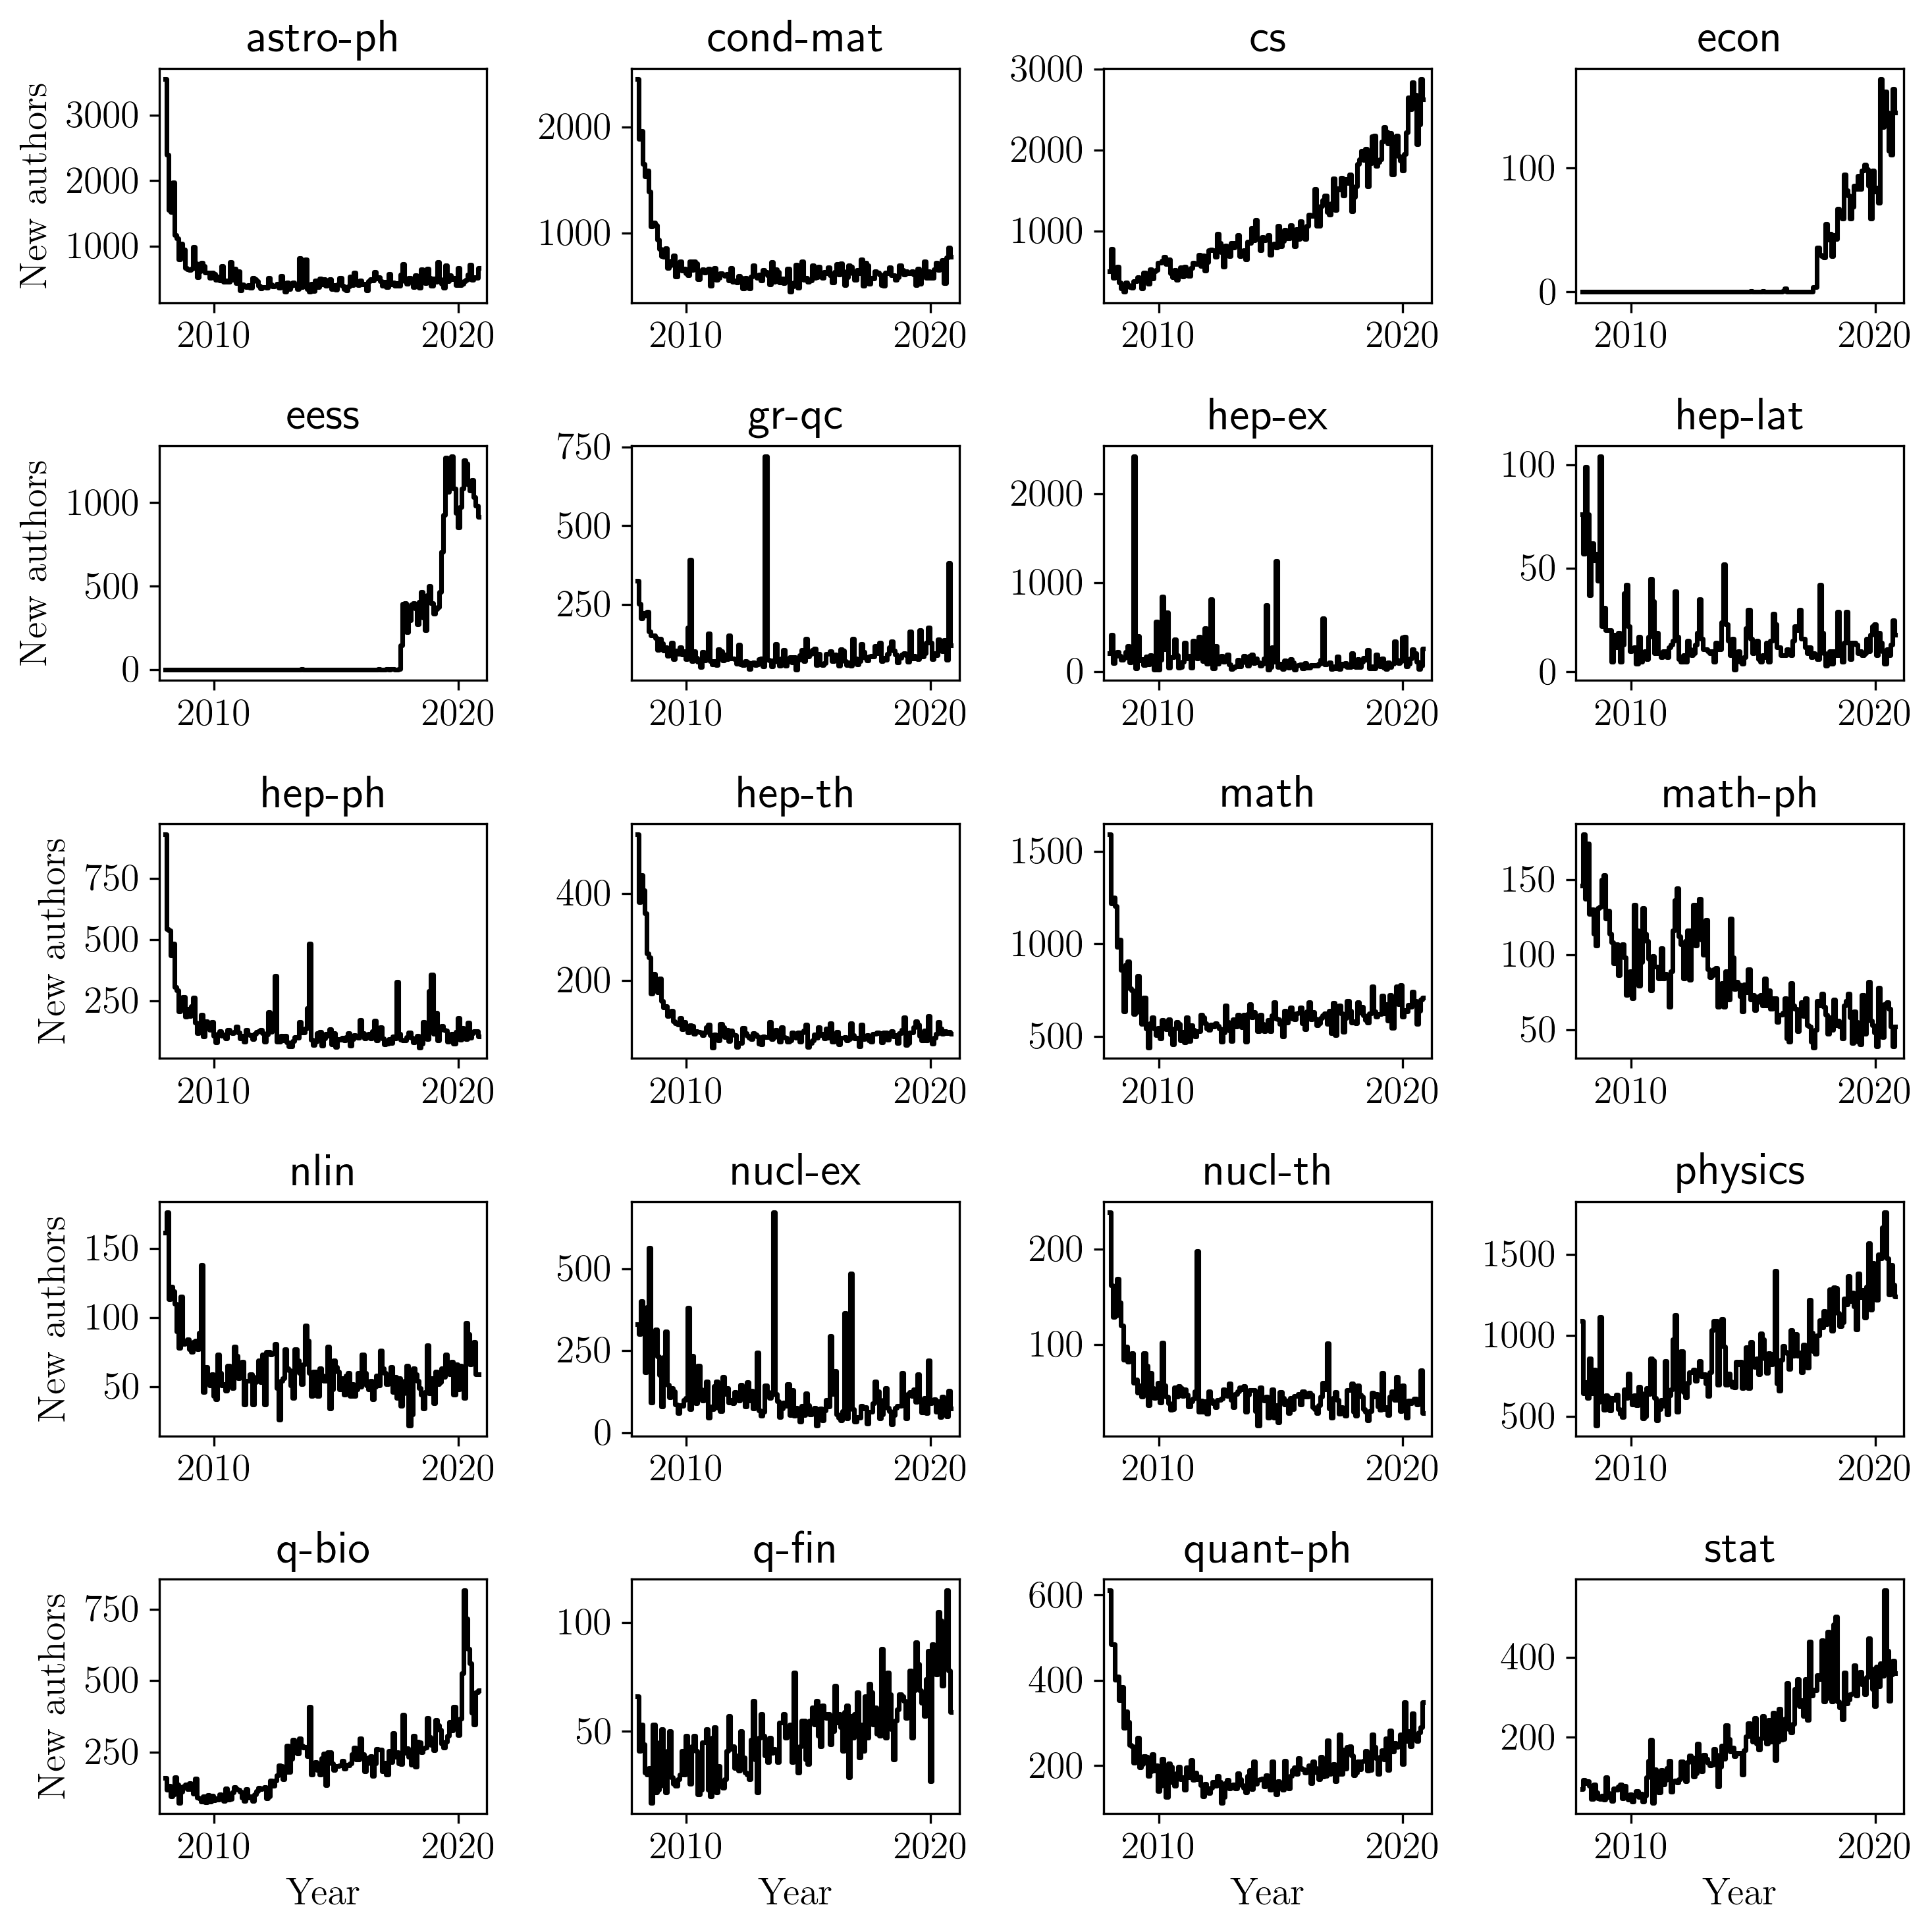

In [14]:
fig, axes = plt.subplots(5, 4)
axes = np.array(axes).flatten()
for ax, (ppc, y, bins) in zip(axes, data_new_authors):
    ax.plot(
        bins[:-1],
        y,
        drawstyle="steps-mid",
        c="k"
    )
    ax.set_title(ppc)
    
    ax.set_xlim(bins[0] - 3/12, bins[-1] + 3/12)
    if ax.is_last_row():
        ax.set_xlabel(r"$\textrm{Year}$")
    
    if ax.is_first_col():
        ax.set_ylabel(r"$\textrm{New~authors}$")

fig.tight_layout()
fig.savefig("article/new-authors-segmented-by-field.pdf", dpi=300)

In [22]:
# Wow! 

# OK, how many papers appear that are *entirely* of new author names, that have never appeared before!

# NOTE: This cell takes about 20 minutes to run!

def get_papers_with_only_new_authors(arxiv_ids, bins=np.arange(2008, 2021, 1/12)):
    d = np.array(list(map(get_decimal_date, arxiv_ids)))
    idx = np.digitize(d, bins)
    
    y = np.zeros(bins.size - 1)
    z = np.zeros(bins.size - 1)
    has_appeared = []
    for i, bin_edge in enumerate(tqdm(bins[:-1])):
        mask = (idx == (i + 1))
        
        for arxiv_id in arxiv_ids[mask]:
            these_authors = list(map(unique_ify, authors[arxiv_id]))

            new_names = set(these_authors).difference(has_appeared)
            has_appeared.extend(list(new_names))
            
            if len(new_names) == len(set(these_authors)):
                y[i] += 1
            
            z[i] += 1
                
    return (y, z, bins)


# Build field-specific profiles
data_only_new_authors = []
for ppc in sorted(list(set(records["primary_parent_category"]))):
    mask = (records["primary_parent_category"] == ppc)
    y, z, bins = get_papers_with_only_new_authors(records["id"][mask])
    data_only_new_authors.append((ppc, y, z, bins))


 21%|██▏       | 33/155 [00:12<00:46,  2.62it/s]


KeyboardInterrupt: 

In [ ]:
fig, axes = plt.subplots(5, 4)
axes = np.array(axes).flatten()
for ax, (ppc, y, z, bins) in zip(axes, data_only_new_authors):
    ax.plot(
        bins[:-1],
        y,
        drawstyle="steps-mid",
        c="k"
    )
    ax.set_title(ppc)
    
    if ax.is_last_row():
        ax.set_xlabel(r"$\textrm{Year}$")
    else:
        ax.set_xticklabels([])

fig.tight_layout()

fig.savefig(f"article/pre-prints-with-entirely-new-authors.pdf", dpi=300)

In [ ]:
# Build field-specific profiles
mask = (records["primary_parent_category"] == "q-bio")

q_bio_only_new_authors = []
for pc in sorted(list(set(records["primary_category"][mask]))):
    sub_mask = mask * (records["primary_category"] == pc)
    y, z, bins = get_papers_with_only_new_authors(records["id"][sub_mask])
    q_bio_only_new_authors.append((pc, y, z, bins))
    
    
fig, axes = plt.subplots(5, 2)
axes = np.array(axes).flatten()
for ax, (pc, y, z, bins) in zip(axes, q_bio_only_new_authors):
    ax.plot(
        bins[:-1],
        y,
        drawstyle="steps-mid",
        c="k"
    )
    ax.set_title(pc)
    
    if ax.is_last_row():
        ax.set_xlabel(r"$\textrm{Year}$")
    else:
        ax.set_xticklabels([])

fig.tight_layout()

fig.savefig(f"article/q-bio-pre-prints-with-entirely-new-authors.pdf", dpi=300)

In [ ]:
# Let's find those pre-prints in 2020 in q-bio with entirely new authors:
fig, ax = plt.subplots()

for ppc, y, z, bins in data_only_new_authors:
    if ppc == "q-bio":
        break
        
ax.plot(
    bins[:-1],
    y,
    drawstyle="steps-mid",
    c="k"
)
ax.axvline(2020 + 1/12)
ax.axvline(2020 + 8/12)
fig.tight_layout()

In [ ]:
# Let's find those pre-prints in 2020 in q-bio with entirely new authors:
fig, ax = plt.subplots()

for ppc, y, z, bins in data_only_new_authors:
    if ppc == "q-bio":
        break
        
ax.plot(
    bins[:-1],
    y,
    drawstyle="steps-mid",
    c="k"
)
ax.axvline(2020 + 1/12)
ax.axvline(2020 + 8/12)
fig.tight_layout()

In [ ]:

def get_paper_ids_with_only_new_authors(arxiv_ids,  bins=np.arange(2008, 2021, 1/12), between=(2020, 2021)):
    d = np.array(list(map(get_decimal_date, arxiv_ids)))
    idx = np.digitize(d, bins)
    
    y = np.zeros(bins.size - 1)
    z = np.zeros(bins.size - 1)
    has_appeared = []
    ids = []
    for i, bin_edge in enumerate(tqdm(bins[:-1])):
        mask = (idx == (i + 1))
        
        for j, arxiv_id in enumerate(arxiv_ids[mask]):
            these_authors = list(map(unique_ify, authors[arxiv_id]))

            new_names = set(these_authors).difference(has_appeared)
            has_appeared.extend(list(new_names))
            
            if len(new_names) == len(set(these_authors)):
                dd = d[mask][j]
                #print(dd, arxiv_id)
                if between[1] >= dd and dd >= between[0]:
                    ids.append((arxiv_id, len(these_authors)))
                y[i] += 1
            
            z[i] += 1
                
    return ids

mask = (records["primary_parent_category"] == "q-bio") \
     * (records["primary_category"] == "q-bio.PE")
new_q_bio_pe_ids = get_paper_ids_with_only_new_authors(
    records["id"][mask],
    between=(2020 + 1/12, 2020 + 8/12)
)



In [ ]:
len(new_q_bio_pe_ids)

with open("abstracts.json", "r") as fp:
    context = json.load(fp)


In [ ]:
matches = ("pandemic", "covid", "sars cov")
new_q_bio_pe_ids_covid = []
for arxiv_id, author_num in new_q_bio_pe_ids:
    text = context[arxiv_id]
    
    compare_text = f"{text['title']} {text['abstract']}"
    compare_words = compare_text.replace("-", " ").lower().split()
    for word in matches:
        if word in compare_words:
            new_q_bio_pe_ids_covid.append(arxiv_id)
            break


In [ ]:
print(len(new_q_bio_pe_ids_covid))
print(len(new_q_bio_pe_ids))

In [ ]:
def f(arxiv_ids,  bins=np.arange(2008, 2021, 1/12)):
    d = np.array(list(map(get_decimal_date, arxiv_ids)))
    idx = np.digitize(d, bins)
    
    y = np.zeros(bins.size - 1)
    z = np.zeros(bins.size - 1)
    g = np.zeros(bins.size - 1)
    has_appeared = []
    for i, bin_edge in enumerate(tqdm(bins[:-1])):
        mask = (idx == (i + 1))
        
        for j, arxiv_id in enumerate(arxiv_ids[mask]):
            these_authors = list(map(unique_ify, authors[arxiv_id]))

            new_names = set(these_authors).difference(has_appeared)
            has_appeared.extend(list(new_names))
            
            if len(new_names) == len(set(these_authors)):
                dd = d[mask][j]
                #print(dd, arxiv_id)
                compare_text = f"{context[arxiv_id]['title']} {context[arxiv_id]['abstract']}".lower()
                for word in ("covid", "sars cov", "pandemic"):
                    if word in compare_text:
                        g[i] += 1
                        break
                        
                y[i] += 1
            
            z[i] += 1
                
    return (y, z, g, bins)


mask = (records["primary_parent_category"] == "q-bio") \
     * (records["primary_category"] == "q-bio.PE")
y, z, g, bins = f(
    records["id"][mask],
)


# Let's find those pre-prints in 2020 in q-bio with entirely new authors:
fig, ax = plt.subplots()

        
ax.plot(
    bins[:-1],
    y,
    drawstyle="steps-mid",
    c="k"
)
ax.plot(
    bins[:-1],
g,
drawstyle="steps-mid",
c="tab:blue")
#ax.axvline(2020 + 1/12)
#ax.axvline(2020 + 8/12)
fig.tight_layout()

In [ ]:
for arxiv_id in new_q_bio_pe_ids_covid:
    print(f"https://arxiv.org/abs/{arxiv_id}")

In [ ]:
# Now let's see for q-bio.PE pre-prints
mask = (records["primary_parent_category"] == "q-bio") \
     * (records["primary_category"] == "q-bio.PE") \
     * (records["created_decimal_year"] >= (2020 + 1/12)) \
     * (records["created_decimal_year"] <= (2020 + 8/12))

len(records[mask])

In [ ]:
# How many are covid-related?
is_covid = np.zeros(len(records[mask]), dtype=bool)
for i, record in enumerate(records[mask]):
    arxiv_id = record["id"]
    compare_text = f"{context[arxiv_id]['title']} {context[arxiv_id]['abstract']}".lower()
    for word in ("sars-cov", "pandemic", "covid"):
        if word in compare_text:
            is_covid[i] = True
            break

print(sum(is_covid))
    

In [ ]:
print(len(new_q_bio_pe_ids_covid))

In [ ]:
# So at least half of the COVID pre-prints in q-bio.PE during the 2020 'peak' were due to entirely new authors!
# (And from looking at those arxiv IDs, most tend to be researchers in other fields:
# not crackpots, but not "new biologists" eitehr)

In [ ]:
for arxiv_id in records["id"][mask][is_covid]:
    if arxiv_id not in new_q_bio_pe_ids_covid:
        print(f"https://arxiv.org/abs/{arxiv_id}")
    

In [51]:
# For each paper in q-bio.PE that is made of entirely new authors, where else have those authors appeared?
# Build field-specific profiles

unique_authors_by_field = {}
ppcs = sorted(list(set(records["primary_parent_category"])))
for ppc in ppcs:
    unique_authors_by_field[ppc] = []

for arxiv_id, ppc in tqdm(zip(records["id"], records["primary_parent_category"]), total=len(records)):
    for author_name in map(unique_ify, authors[arxiv_id]):
        unique_authors_by_field[ppc].append(author_name)


for ppc in ppcs:
    unique_authors_by_field[ppc] = sorted(list(set(unique_authors_by_field[ppc])))


100%|██████████| 1379332/1379332 [00:09<00:00, 150150.35it/s]


In [52]:

ppcs = sorted(list(set(records["primary_parent_category"])))



def get_papers_with_only_new_authors_relative_to_parent(
        parent_arxiv_ids,
        arxiv_ids,
        N,
        bins=np.arange(2008, 2021, 1/12)
    ):
    
    d = np.array(list(map(get_decimal_date, parent_arxiv_ids)))
    idx = np.digitize(d, bins)
    
    y = np.zeros(bins.size - 1)
    z = np.zeros(bins.size - 1)
    G = np.zeros((bins.size - 1, len(ppcs)))
    
    has_appeared = []
    new_ids = []
    for i, bin_edge in enumerate(tqdm(bins[:-1])):
        mask = (idx == (i + 1))
        
        for arxiv_id in parent_arxiv_ids[mask]:
            these_authors = list(map(unique_ify, authors[arxiv_id]))
            new_names = set(these_authors).difference(has_appeared)
            has_appeared.extend(list(new_names))

            if arxiv_id in arxiv_ids:    
                if (N is None and len(new_names) == len(set(these_authors))) \
                or (len(new_names) >= N):
                    y[i] += 1
                    new_ids.append(arxiv_id)
                    # Find out whether these names have appeared before.
                    G_row = np.zeros(len(ppcs))
                    for new_name in new_names:
                        for j, ppc in enumerate(ppcs):
                            if ppc == "q_bio": continue
                            if new_name in unique_authors_by_field[ppc]:
                                G_row[j] += 1
                    G_row /= np.sum(G_row)
                    G[i, :] += G_row
            z[i] += 1
                
    return (y, z, bins, new_ids, G)

q_bio_y, q_bio_z, q_bio_bins, q_bio_new_arxiv_ids, q_bio_G = get_papers_with_only_new_authors_relative_to_parent(
    records["id"][(records["primary_parent_category"] == "q-bio")],
    records["id"][(records["primary_category"] == "q-bio.PE")],
    N=None
)



100%|██████████| 155/155 [02:36<00:00,  1.01s/it]


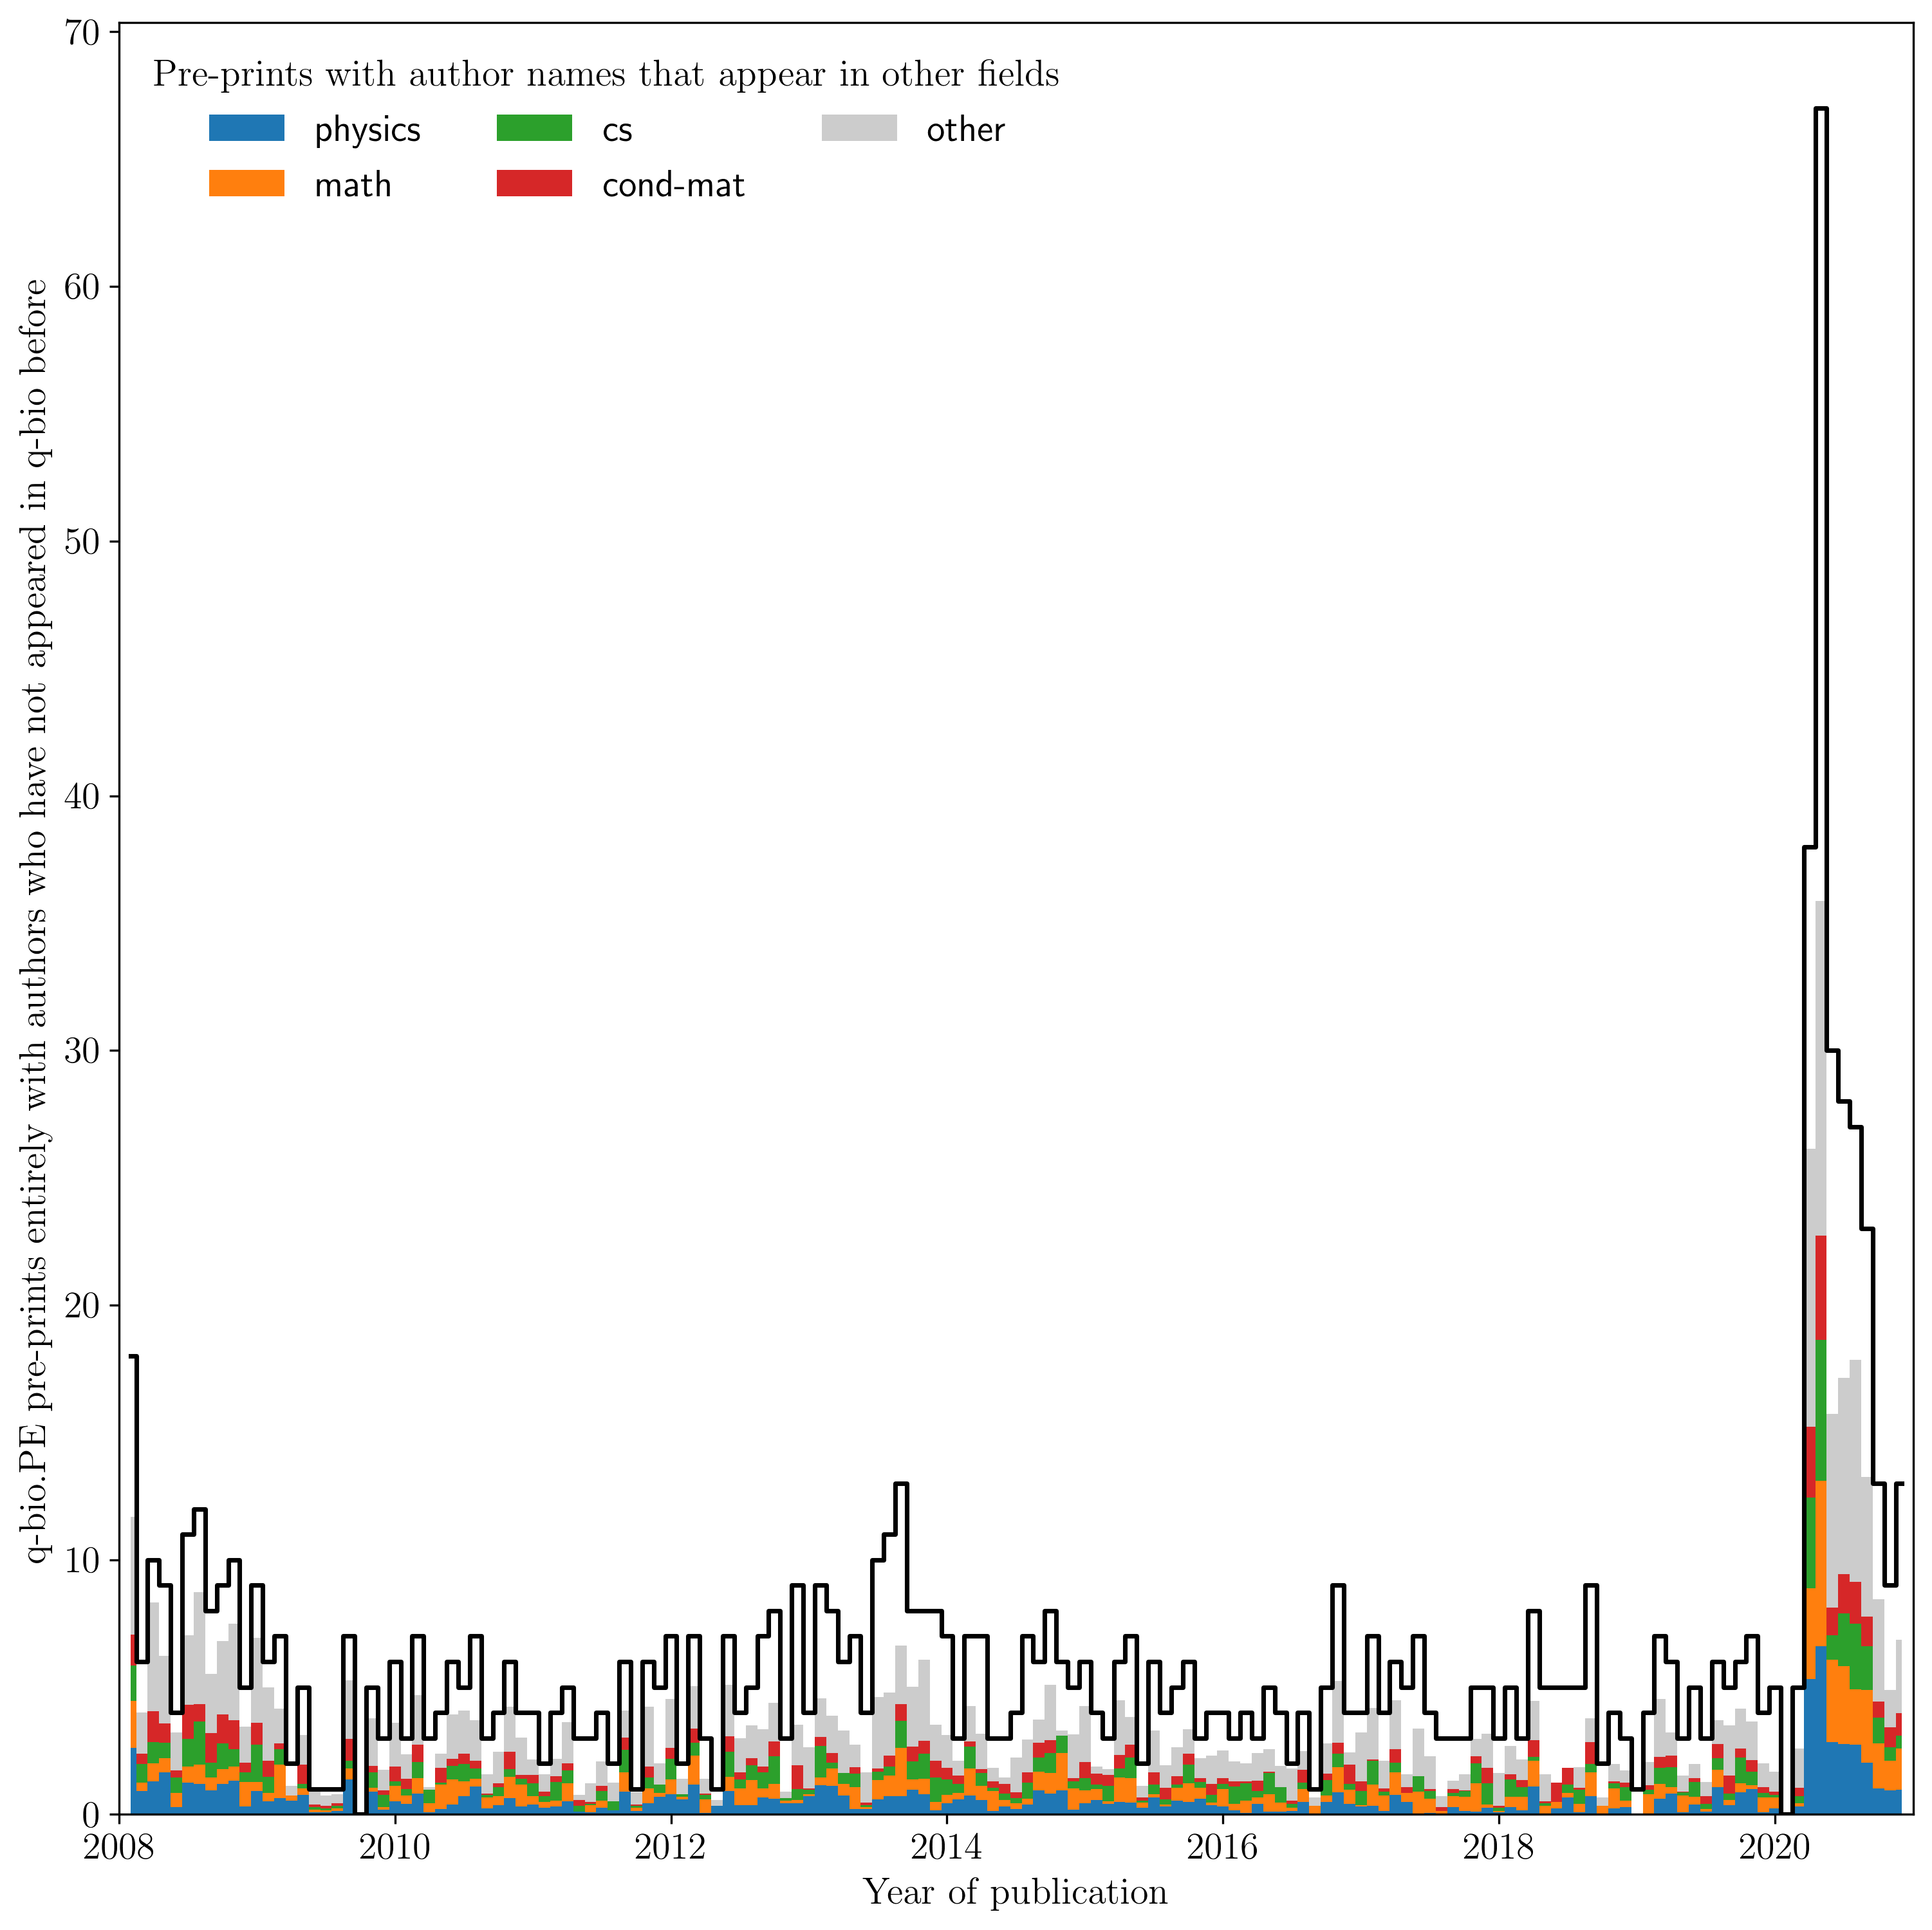

In [89]:
fig, ax = plt.subplots()
sum_G = np.zeros(bins.size - 1)

indices = np.argsort(np.sum(q_bio_G, axis=0))[::-1]
show_max = 5
for j, i in enumerate(indices):
    ppc = ppcs[i]
    if ppc == "q-bio":
        continue
    if j >= show_max:
        ax.fill_between(
            bins[1:],
            sum_G,
            sum_G + np.sum(q_bio_G[:, indices[j:]], axis=1),
            label="other",
            step="mid",
            facecolor="#cccccc"
        )
        break
        
    else:
        ax.fill_between(
            bins[1:],
            sum_G,
            sum_G + q_bio_G[:, i],
            #drawstyle="steps-mid",
            label=ppc,
            step="mid",
        )
        sum_G += q_bio_G[:, i]
    
#ax.plot(bins[1:], np.sum(q_bio_G, axis=1) - q_bio_G[:, ppcs.index("q-bio")], c="k", drawstyle="steps-mid")
ax.plot(bins[1:], q_bio_y, c='k', drawstyle="steps-mid")
ax.set_xlim(2008, 2021)
ax.set_ylim(0, ax.get_ylim()[1])
fig.tight_layout()
ax.legend(loc="upper left", ncol=3, frameon=False, title=r"$\textrm{Pre-prints~with~author~names~that~appear~in~other~fields}$")
ax.set_xlabel(r"$\textrm{Year of publication}$")
ax.set_ylabel(r"$\textrm{q-bio.PE~pre-prints~entirely~with~authors~who~have~not~appeared~in~q-bio~before}$")
fig.savefig("article/q-bio-pre-prints-with-author-overlap.pdf", dpi=300)

In [57]:
# Is it just by chance? What are the number of unique author names by field?
for ppc, a in sorted(unique_authors_by_field.items(), key=lambda _: len(_[1]), reverse=True):
    print(f"{ppc}: {len(a)}")

cs: 172711
physics: 140571
cond-mat: 108372
math: 98569
astro-ph: 87608
q-bio: 34084
quant-ph: 32966
stat: 31376
eess: 28103
hep-ex: 27394
hep-ph: 22714
nucl-ex: 19375
gr-qc: 16680
hep-th: 15203
math-ph: 13084
nlin: 9917
nucl-th: 8144
q-fin: 7818
econ: 3448
hep-lat: 2745


In [ ]:
# cs, physics, cond-mat and math are the fourth largest fields by unique names. 
# But physics and math is over-represented!


In [86]:
# How many pre-prints entierly written by new authors?
np.sum(q_bio_y[bins[1:] >= 2020])

253.0

In [87]:
bins[1:][143]

2019.999999999989

In [61]:

def get_papers_with_at_least_N_new_author(arxiv_ids, N, bins=np.arange(2008, 2021, 1/12)):
    d = np.array(list(map(get_decimal_date, arxiv_ids)))
    idx = np.digitize(d, bins)
    
    y = np.zeros(bins.size - 1)
    z = np.zeros(bins.size - 1)
    has_appeared = []
    for i, bin_edge in enumerate(tqdm(bins[:-1])):
        mask = (idx == (i + 1))
        
        for arxiv_id in arxiv_ids[mask]:
            these_authors = list(map(unique_ify, authors[arxiv_id]))

            new_names = set(these_authors).difference(has_appeared)
            has_appeared.extend(list(new_names))
            
            if N is None:
                if len(new_names) == len(set(these_authors)):
                    y[i] += 1
            else:
                if len(new_names) >= N:
                    y[i] += 1
            
            z[i] += 1
        
    return (y, z, bins)

mask = records["id"][records["primary_parent_category"] == "q-bio"]
#mask = records["id"][records["primary_category"] == "q-bio.PE"]

y, z, bins = get_papers_with_at_least_N_new_author(
    mask,
    N=None
)

100%|██████████| 155/155 [00:05<00:00, 29.56it/s]


In [53]:
# 40% of those in q-bio.PE who are all new authors (never posted to q-bio.PE before)
# 21% of those in q-bio who are all new authors (never posted to q-bio before)
#

253.0
2578.0
0.10


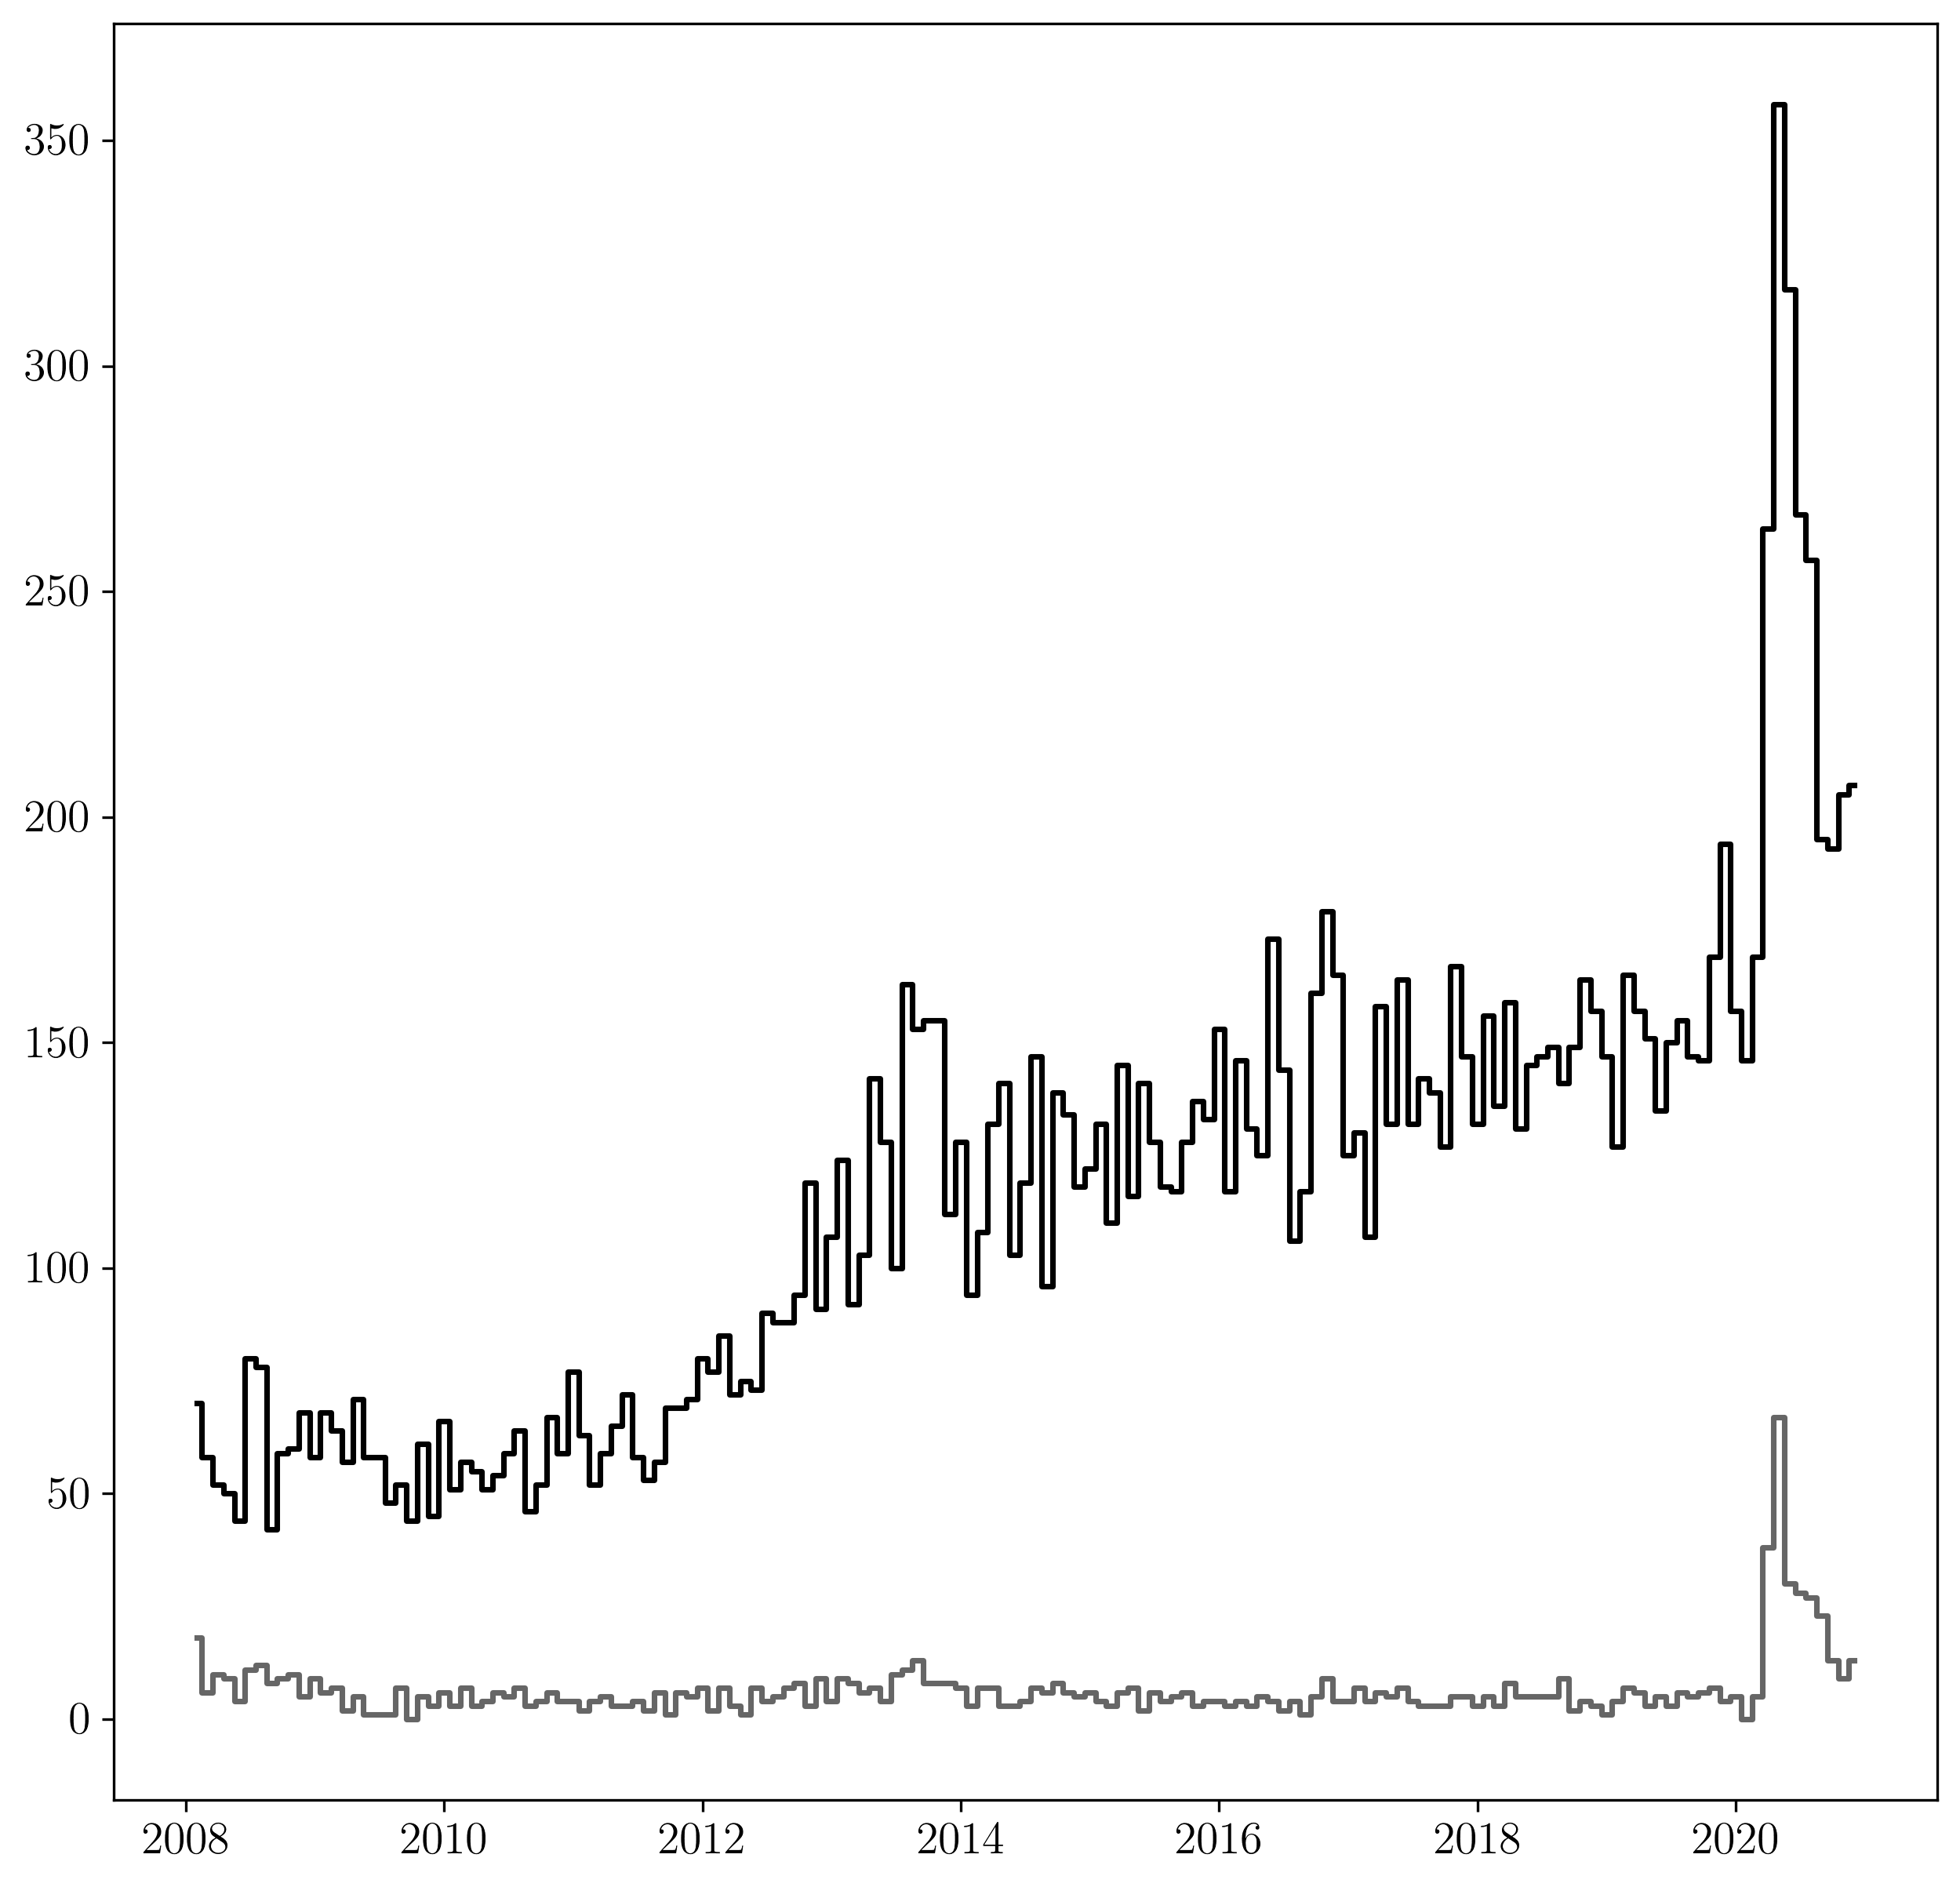

In [55]:
fig, ax = plt.subplots()
ax.plot(q_bio_bins[1:], q_bio_y, drawstyle="steps-mid", c="#666666")
ax.plot(q_bio_bins[1:], q_bio_z, drawstyle="steps-mid", c="k")
is_2020 = q_bio_bins[1:] > 2020
A, B = (np.sum(q_bio_y[is_2020]), np.sum(q_bio_z[is_2020]))
print(A)
print(B)
print(f"{A/B:.2f}")

544.0
2578.0
0.21
3388.0 15496.0
0.22


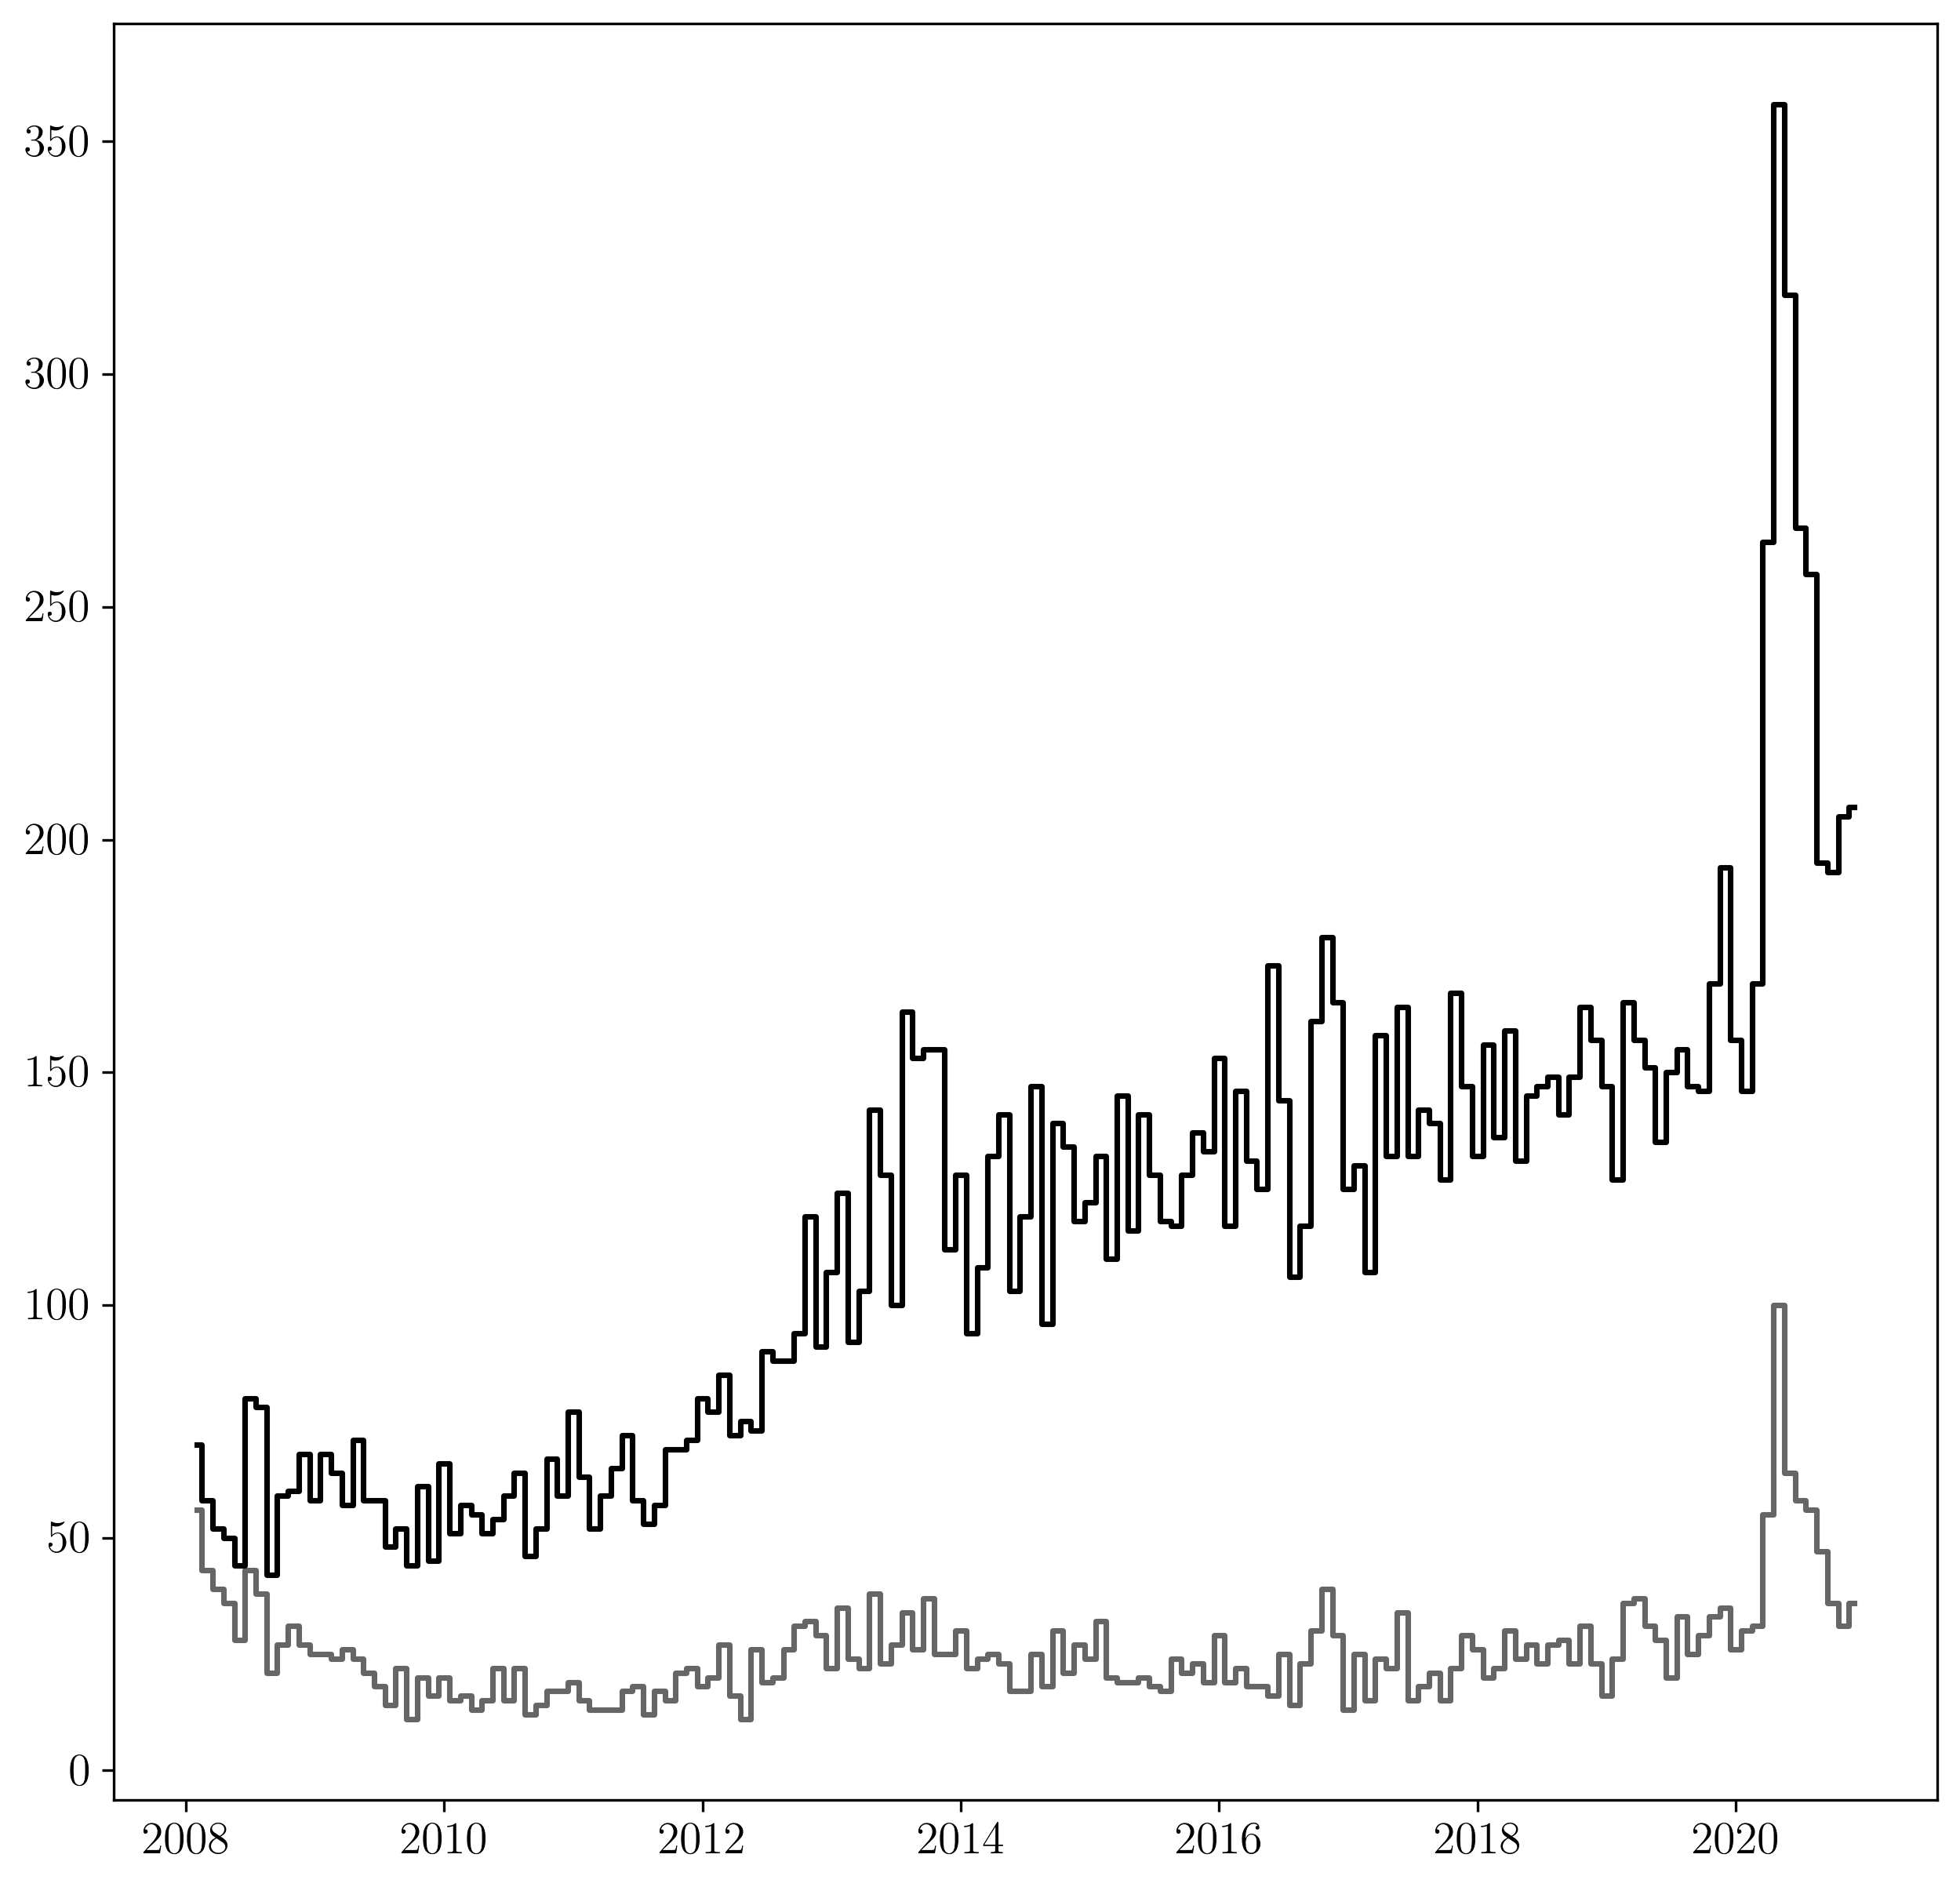

In [62]:
fig, ax = plt.subplots()
ax.plot(bins[1:], y, drawstyle="steps-mid", c="#666666")
ax.plot(bins[1:], z, drawstyle="steps-mid", c="k")
is_2020 = bins[1:] > 2020
A, B = (np.sum(y[is_2020]), np.sum(z[is_2020]))
A_0, B_0 = (np.sum(y[~is_2020]), np.sum(z[~is_2020]))

print(A)
print(B)
print(f"{A/B:.2f}")
print(A_0, B_0)
print(f"{A_0/B_0:.2f}")

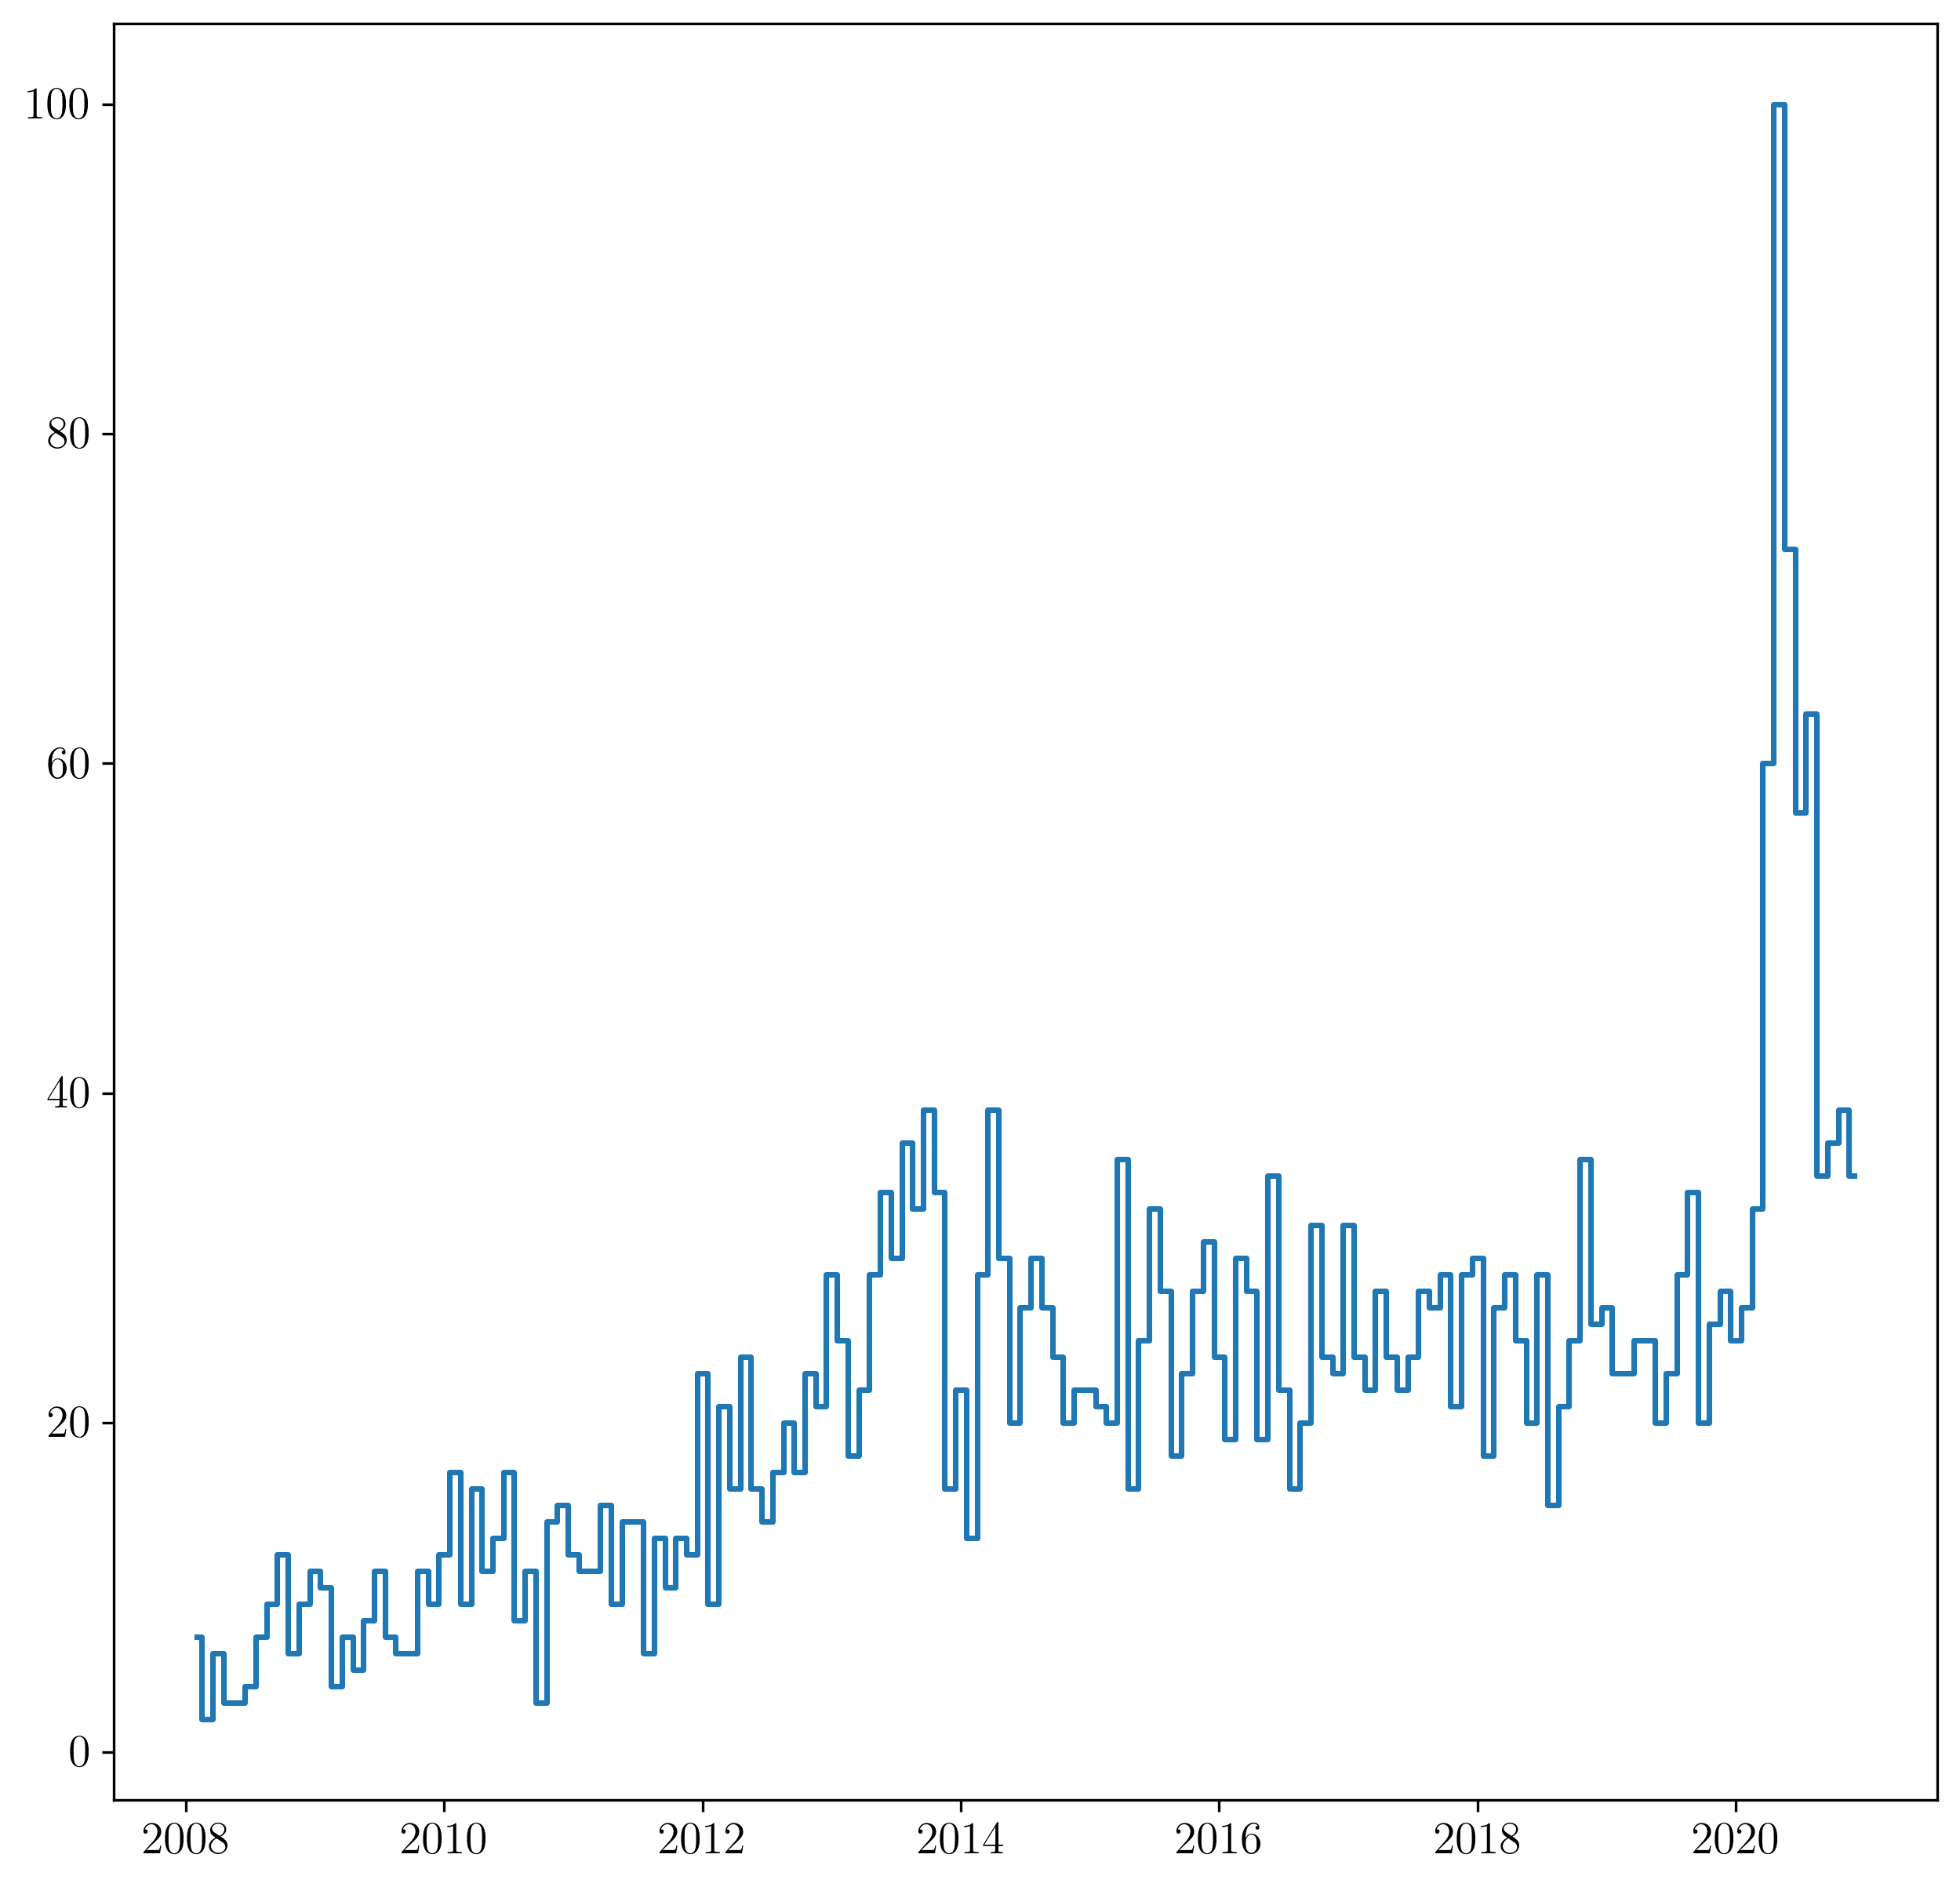

In [43]:
fig, ax = plt.subplots()
ax.plot(bins[1:], (z-y), drawstyle="steps-mid")